In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor
import uproot
import json

import numpy as np
np.seterr(divide='ignore', invalid='ignore', over='ignore')
import matplotlib.pyplot as plt
from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged
from FireHydrant.Tools.trigger import Triggers
from FireHydrant.Tools.metfilter import MetFilters

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
print("Getting background files from .json...")
datasets_ = json.load(open('2018.json'))
bkgdatasets = {}
for group in datasets_.keys():
    if 'DoubleMuon' in group: continue #not data
    if 'CRAB_PrivateMC' in group: continue #not signal
    files = datasets_[group]['files']
    bkgdatasets[group] = [files] #normal background
            
print("Getting signal files from .json...")
datasets_ = json.load(open('2018.json'))
sigdatasets = []
for group in datasets_.keys():
    if not ('CRAB_PrivateMC' in group): continue #not data or background
    files = datasets_[group]['files']
    for file in files: sigdatasets.append(file)
    
print("Files gotten!")

Getting background files from .json...
Getting signal files from .json...
Files gotten!


In [3]:
lssig4mu = []
lssig2mu2e = []

for path in sigdatasets:
    if '4Mu' in path:
        lssig4mu.append(path)
    else:
        lssig2mu2e.append(path)

In [4]:
electdataset=dict(
    sig2mu2e={'files': [], 'treename': 'ffNtuplizer/ffNtuple'},
)

electdataset['sig2mu2e']['files'].extend(lssig2mu2e)

In [5]:
mudataset=dict(
    sig4mu={'files': [], 'treename': 'ffNtuplizer/ffNtuple'},
)

mudataset['sig4mu']['files'].extend(lssig4mu)

In [47]:
class ElectronLeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'electron signal datasets')
        match_axis   = hist.Cat('match', 'matched')
        pt_axis       = hist.Bin("pt", "pT [GeV]", 50, 0, 800)
        eta_axis      = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        nef_axis      = hist.Bin("nef", "neutral energy fraction", 50, 0, 1)
        maxd0_axis    = hist.Bin("maxd0", 'track max |d0|', 50, 0, 0.5)
        mind0_axis    = hist.Bin("mind0", 'track min |d0|', 50, 0, 0.5)
        tkiso_axis    = hist.Bin('tkiso', 'track isolation', 50, 0, 1)
        pfiso_axis    = hist.Bin("pfiso", "PFCands isolation", 50, 0, 1)
        spreadpt_axis = hist.Bin("spreadpt", "spreadpt", 50, 0, 1)
        spreaddr_axis = hist.Bin("spreaddr", "spreaddr", 50, 0, 0.1)
        lambda_axis   = hist.Bin('lamb', 'jet sub - lambda', 50, -8, 0)
        epsilon_axis  = hist.Bin('epsi', 'jet sub - epsilon', 50, 0, 0.25)
        ecfe1_axis    = hist.Bin('ecfe1', 'energy correlation function - e1', 50, 0, 750)
        ecfe2_axis    = hist.Bin('ecfe2', 'energy correlation function - e2', 50, 0, 2000)
        ecfe3_axis    = hist.Bin('ecfe3', 'energy correlation function - e3', 50, 0, 1000)
        mva_axis      = hist.Bin('mva', 'BDT value', 50, -10, 10)
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("#counts/16GeV", dataset_axis, pt_axis, match_axis),
            "eta": hist.Hist("#counts/0.096", dataset_axis, eta_axis, match_axis),
            "nef": hist.Hist("#counts/0.02", dataset_axis, nef_axis, match_axis),
            "maxd0": hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis, match_axis),
            "mind0": hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis, match_axis),
            "tkiso": hist.Hist("#counts/0.02", dataset_axis, tkiso_axis, match_axis),
            "pfiso": hist.Hist("#counts/0.02", dataset_axis, pfiso_axis, match_axis),
            "spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis, match_axis),
            "spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis, match_axis),
            "lamb": hist.Hist("#counts/0.16", dataset_axis, lambda_axis, match_axis),
            "epsi": hist.Hist("#counts/0.005", dataset_axis, epsilon_axis, match_axis),
            "ecfe1": hist.Hist("#counts/25", dataset_axis, ecfe1_axis, match_axis),
            "ecfe2": hist.Hist("#counts/40", dataset_axis, ecfe2_axis, match_axis),
            "ecfe3": hist.Hist("#counts/20", dataset_axis, ecfe3_axis, match_axis),
            "mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis, match_axis),
        })

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        maxd0_ = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0).max()
        mind0_ = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0).min()
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            nef=(df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT'],
            maxd0=maxd0_.content,
            mind0=mind0_.content,
            tkiso=df['pfjet_tkIsolation05'],
            pfiso=df['pfjet_pfIsolation05'],
            spreadpt=df['pfjet_ptDistribution'],
            spreaddr=df['pfjet_dRSpread'],
            lamb=df['pfjet_subjet_lambda'],
            epsi=df['pfjet_subjet_epsilon'],
            ecf1=df['pfjet_subjet_ecf1'],
            ecf2=df['pfjet_subjet_ecf2'],
            ecf3=df['pfjet_subjet_ecf3'],
            mva=df['pfjet_mva'],
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid'],
        )
        darkphotons = genparticles[genparticles.pid==32]
        electrons = genparticles[genparticles.pid==11]
        eleLJ = leptonjets[leptonjets.match(electrons, deltaRCut=0.3)]
        matchmask = eleLJ.match(darkphotons, deltaRCut=0.3)
        finalcheck = leptonjets.match(eleLJ[matchmask], deltaRCut=0.01)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        
        leptonjets_t = eleLJ[matchmask][metfiltermask&triggermask]
        leptonjets_f = leptonjets[~finalcheck][metfiltermask&triggermask]

        
        output['pt']      .fill(dataset=dataset, match='matched', pt=leptonjets_t.pt.flatten())
        output['eta']     .fill(dataset=dataset, match='matched', eta=leptonjets_t.eta.flatten())
        output['nef']     .fill(dataset=dataset, match='matched', nef=leptonjets_t.nef.flatten())
        output['maxd0']   .fill(dataset=dataset, match='matched', maxd0=leptonjets_t.maxd0.flatten())
        output['mind0']   .fill(dataset=dataset, match='matched', mind0=leptonjets_t.mind0.flatten())
        output['tkiso']   .fill(dataset=dataset, match='matched', tkiso=leptonjets_t.tkiso.flatten())
        output['pfiso']   .fill(dataset=dataset, match='matched', pfiso=leptonjets_t.pfiso.flatten())
        output['spreadpt'].fill(dataset=dataset, match='matched', spreadpt=leptonjets_t.spreadpt.flatten())
        output['spreaddr'].fill(dataset=dataset, match='matched', spreaddr=leptonjets_t.spreaddr.flatten())
        output['lamb']    .fill(dataset=dataset, match='matched', lamb=leptonjets_t.lamb.flatten())
        output['epsi']    .fill(dataset=dataset, match='matched', epsi=leptonjets_t.epsi.flatten())
        output['ecfe1']   .fill(dataset=dataset, match='matched', ecfe1=leptonjets_t.ecf1.flatten())
        output['ecfe2']   .fill(dataset=dataset, match='matched', ecfe2=leptonjets_t.ecf2.flatten())
        output['ecfe3']   .fill(dataset=dataset, match='matched', ecfe3=leptonjets_t.ecf3.flatten())
        output['mva']     .fill(dataset=dataset, match='matched', mva=leptonjets_t.mva.flatten())
        
        output['pt']      .fill(dataset=dataset, match='unmatched', pt=leptonjets_f.pt.flatten())
        output['eta']     .fill(dataset=dataset, match='unmatched', eta=leptonjets_f.eta.flatten())
        output['nef']     .fill(dataset=dataset, match='unmatched', nef=leptonjets_f.nef.flatten())
        output['maxd0']   .fill(dataset=dataset, match='unmatched', maxd0=leptonjets_f.maxd0.flatten())
        output['mind0']   .fill(dataset=dataset, match='unmatched', mind0=leptonjets_f.mind0.flatten())
        output['tkiso']   .fill(dataset=dataset, match='unmatched', tkiso=leptonjets_f.tkiso.flatten())
        output['pfiso']   .fill(dataset=dataset, match='unmatched', pfiso=leptonjets_f.pfiso.flatten())
        output['spreadpt'].fill(dataset=dataset, match='unmatched', spreadpt=leptonjets_f.spreadpt.flatten())
        output['spreaddr'].fill(dataset=dataset, match='unmatched', spreaddr=leptonjets_f.spreaddr.flatten())
        output['lamb']    .fill(dataset=dataset, match='unmatched', lamb=leptonjets_f.lamb.flatten())
        output['epsi']    .fill(dataset=dataset, match='unmatched', epsi=leptonjets_f.epsi.flatten())
        output['ecfe1']   .fill(dataset=dataset, match='unmatched', ecfe1=leptonjets_f.ecf1.flatten())
        output['ecfe2']   .fill(dataset=dataset, match='unmatched', ecfe2=leptonjets_f.ecf2.flatten())
        output['ecfe3']   .fill(dataset=dataset, match='unmatched', ecfe3=leptonjets_f.ecf3.flatten())
        output['mva']     .fill(dataset=dataset, match='unmatched', mva=leptonjets_f.mva.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [48]:
output = processor.run_uproot_job(electdataset,
                                  treename=None,
                                  processor_instance=ElectronLeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 150/150 [00:16<00:00,  9.23items/s]


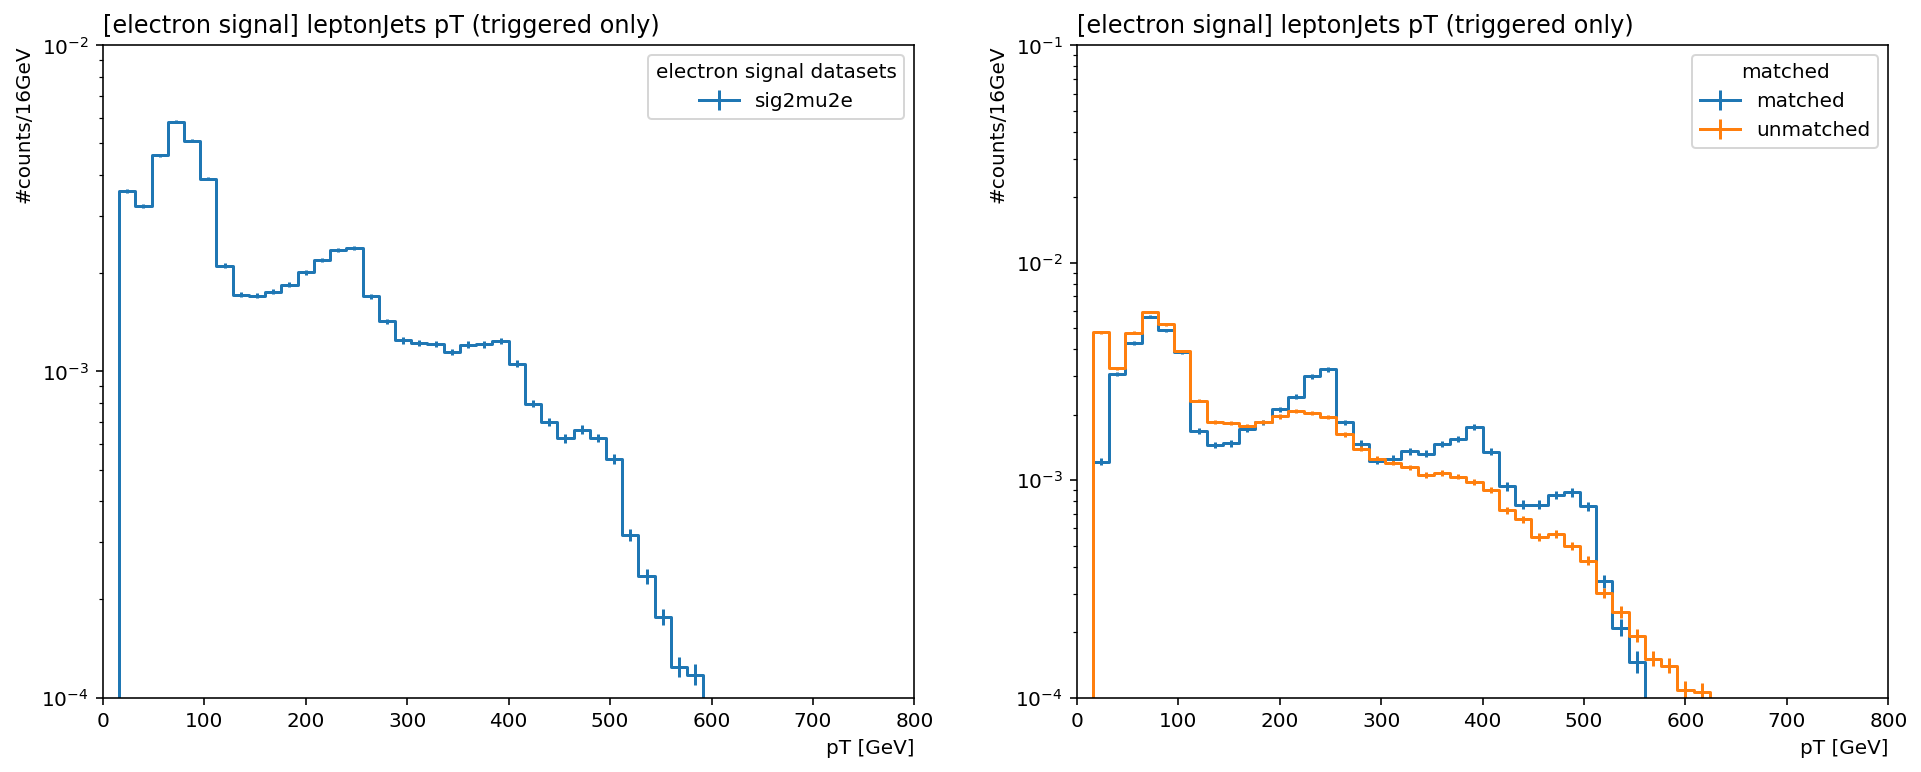

In [49]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['pt'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['pt'].project('dataset'), overlay='match', ax=axes[1], density=True)
axes[0].set_ylim([1e-4, 1e-2])
axes[1].set_ylim([1e-4, 1e-1])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[electron signal] leptonJets pT (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

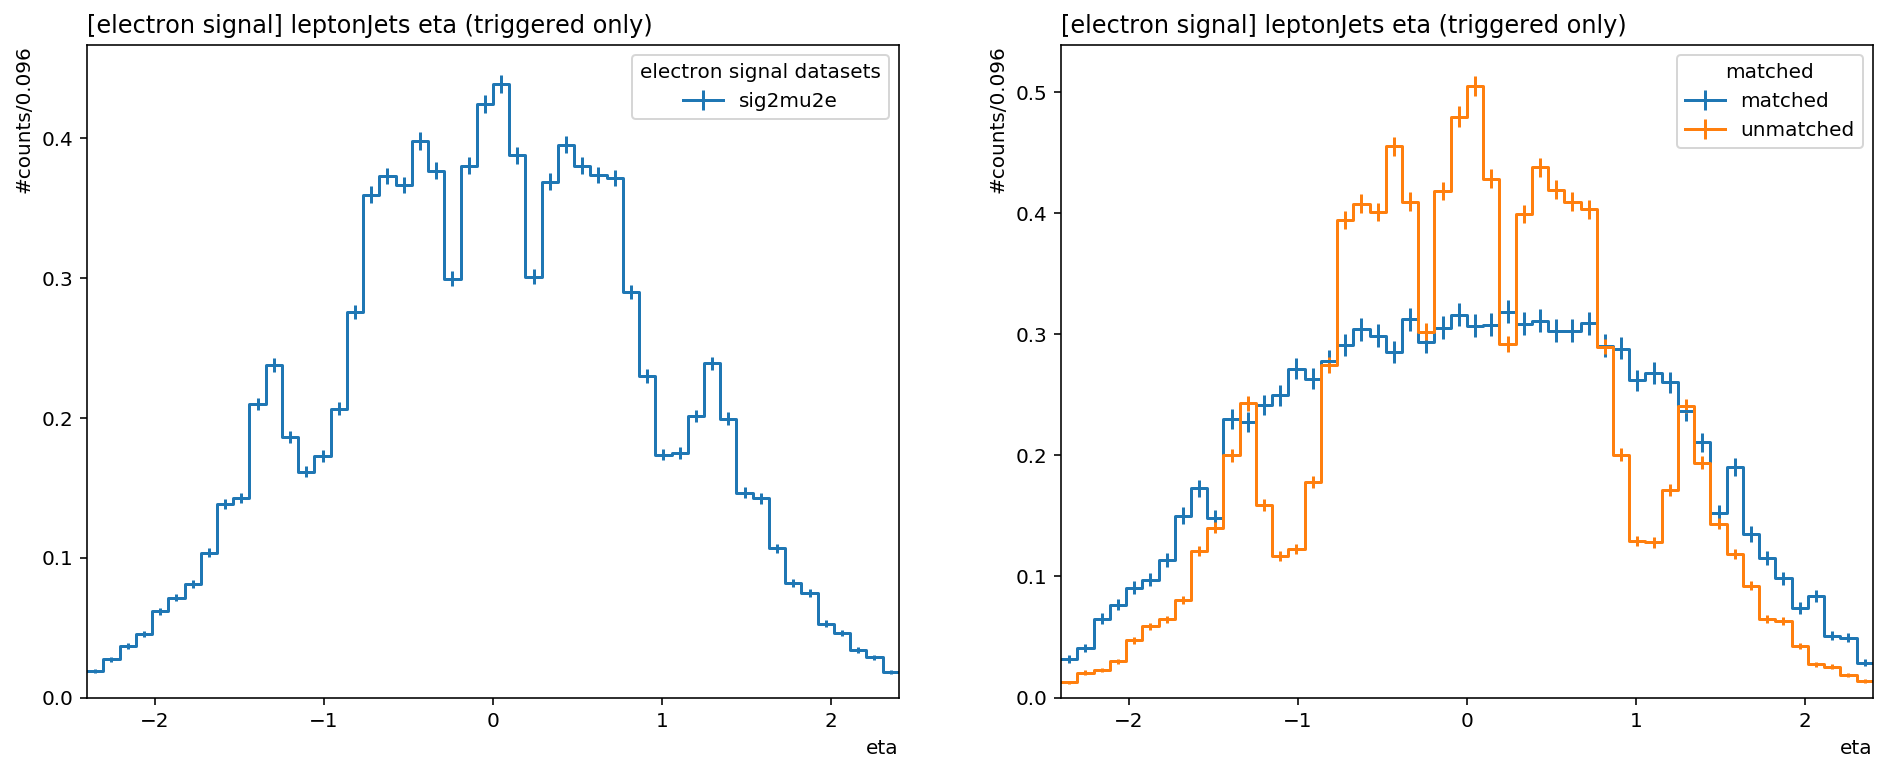

In [50]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['eta'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['eta'].project('dataset'), overlay='match', ax=axes[1], density=True)


for ax in axes:
    ax.set_title('[electron signal] leptonJets eta (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

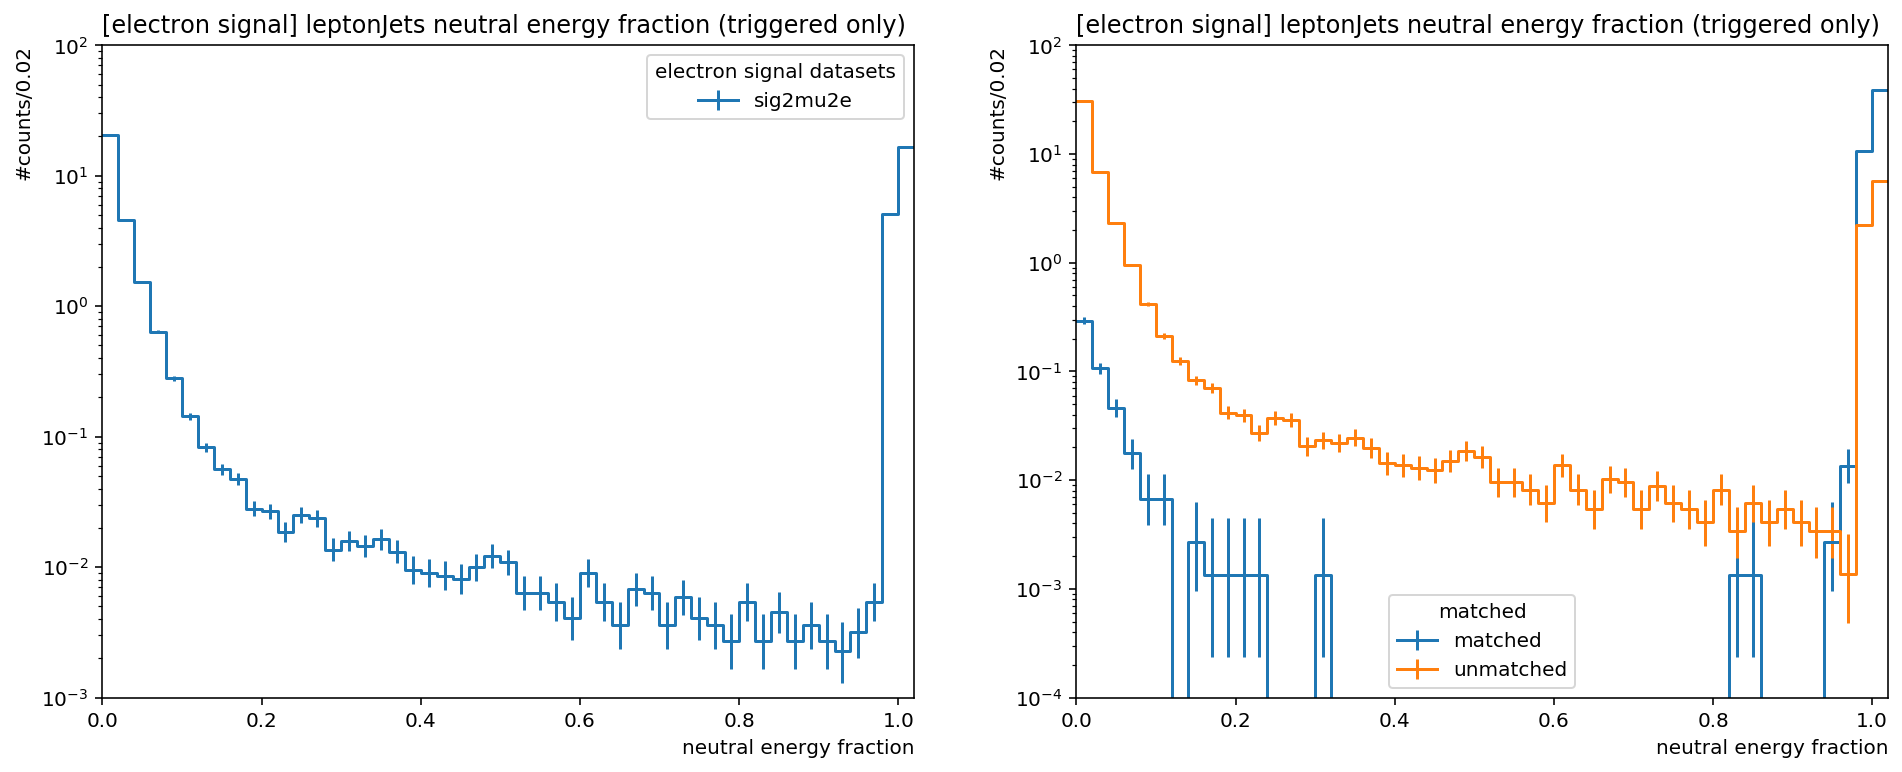

In [51]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['nef'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='over')
fig, ax, _ = hist.plot1d(output['nef'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='over')
axes[0].set_ylim([1e-3, 1e2])
axes[1].set_ylim([1e-4, 1e2])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[electron signal] leptonJets neutral energy fraction (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

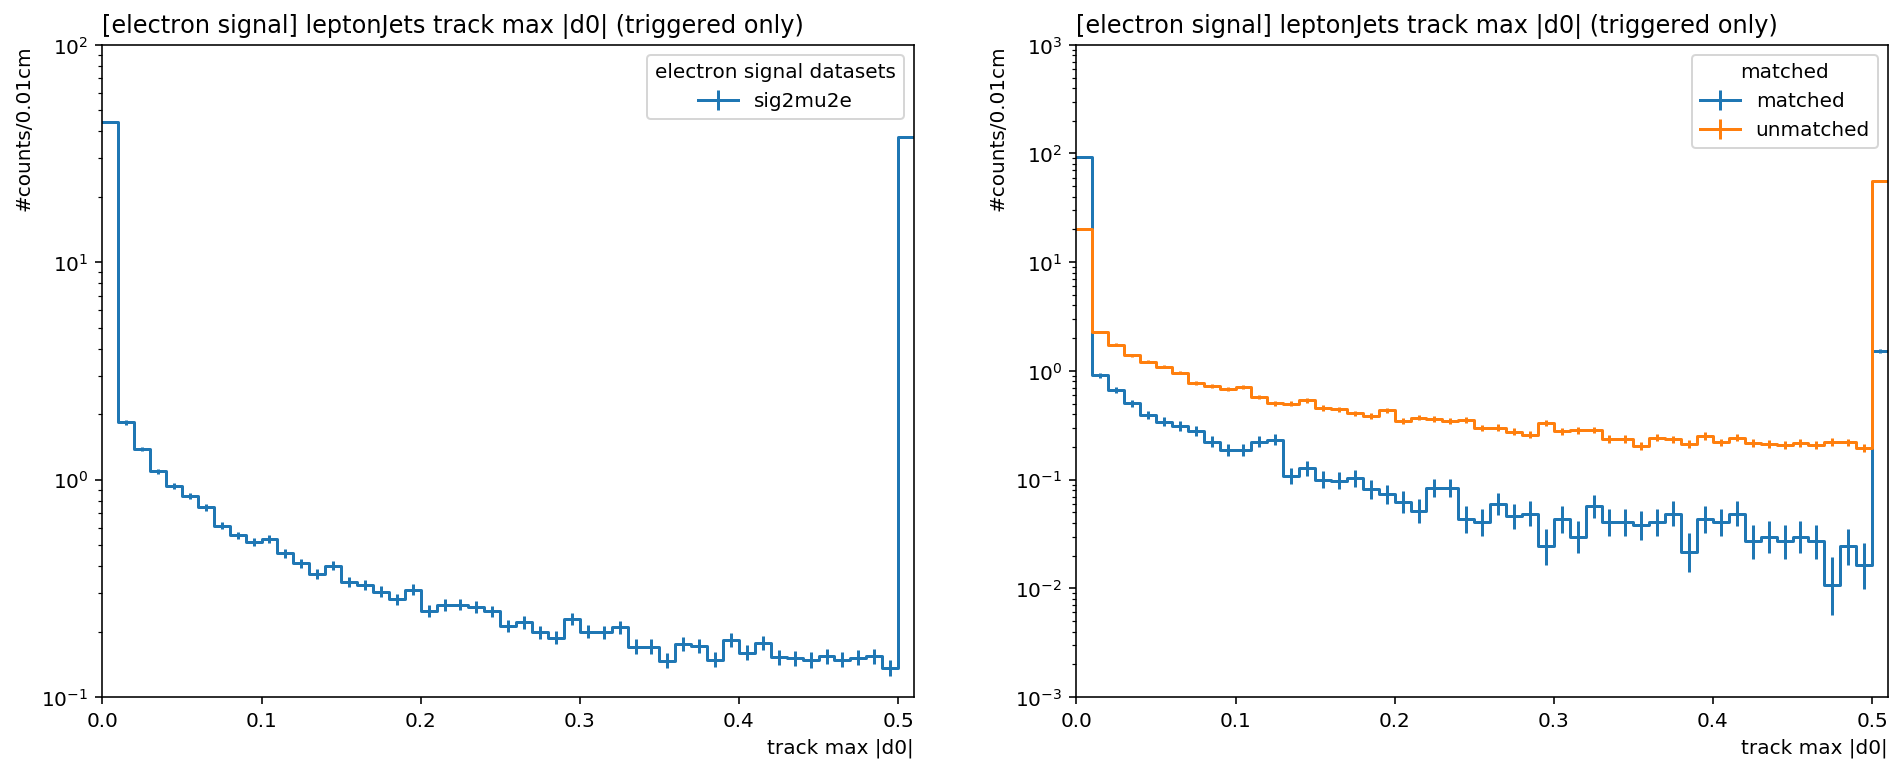

In [52]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['maxd0'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='over')
fig, ax, _ = hist.plot1d(output['maxd0'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='over')
axes[0].set_ylim([1e-1, 1e2])
axes[1].set_ylim([1e-3, 1e3])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[electron signal] leptonJets track max |d0| (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

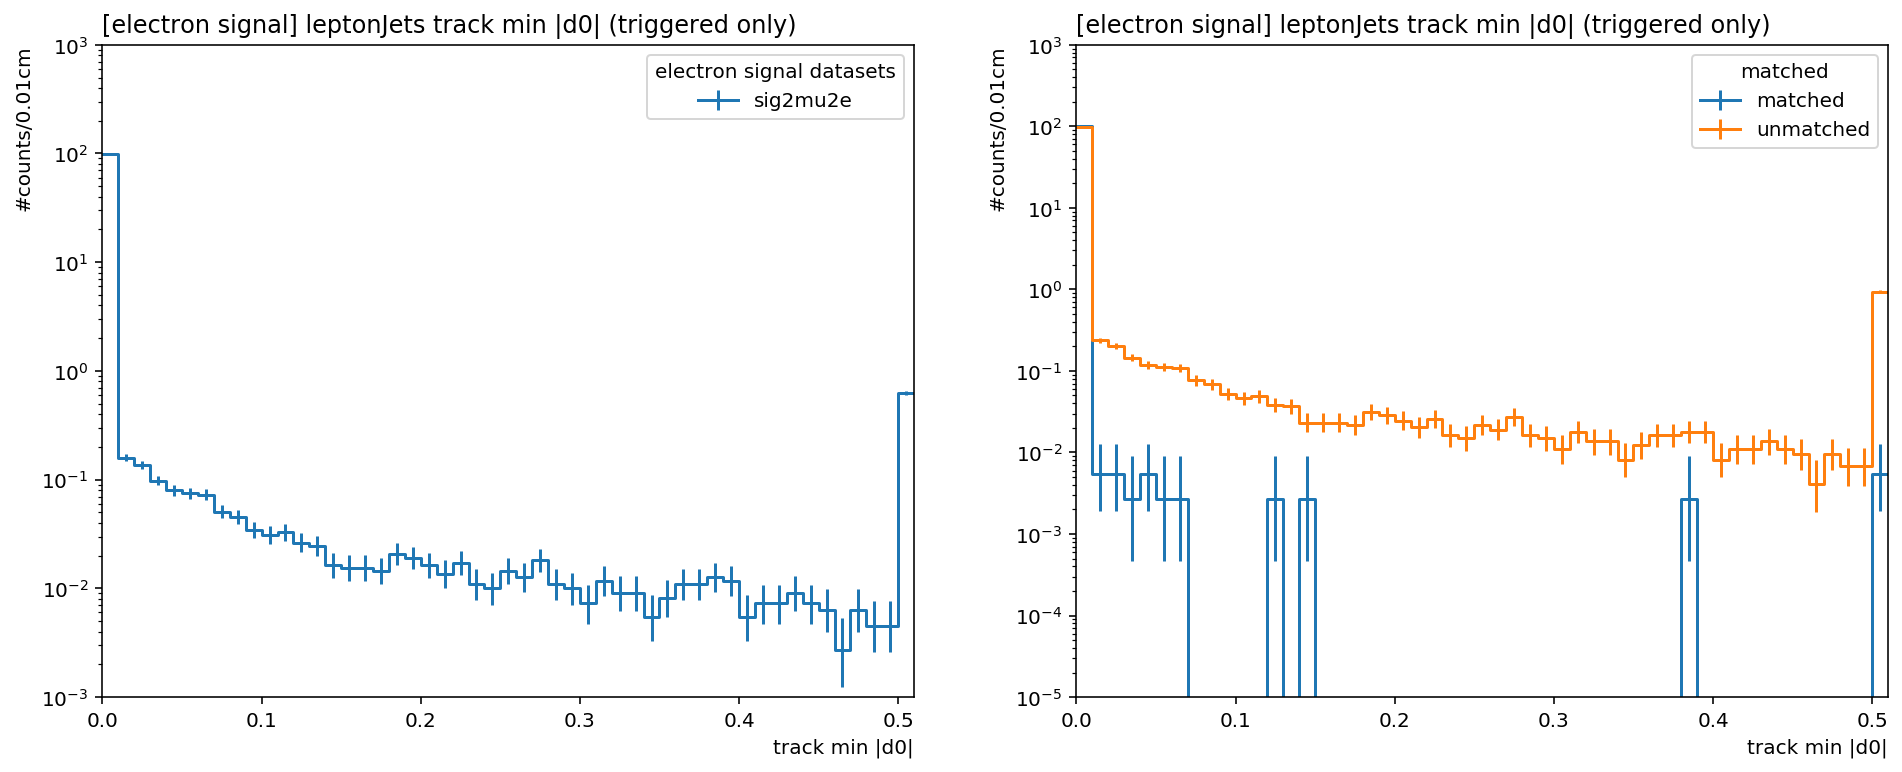

In [53]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['mind0'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='over')
fig, ax, _ = hist.plot1d(output['mind0'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='over')
axes[0].set_ylim([1e-3, 1e3])
axes[1].set_ylim([1e-5, 1e3])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[electron signal] leptonJets track min |d0| (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

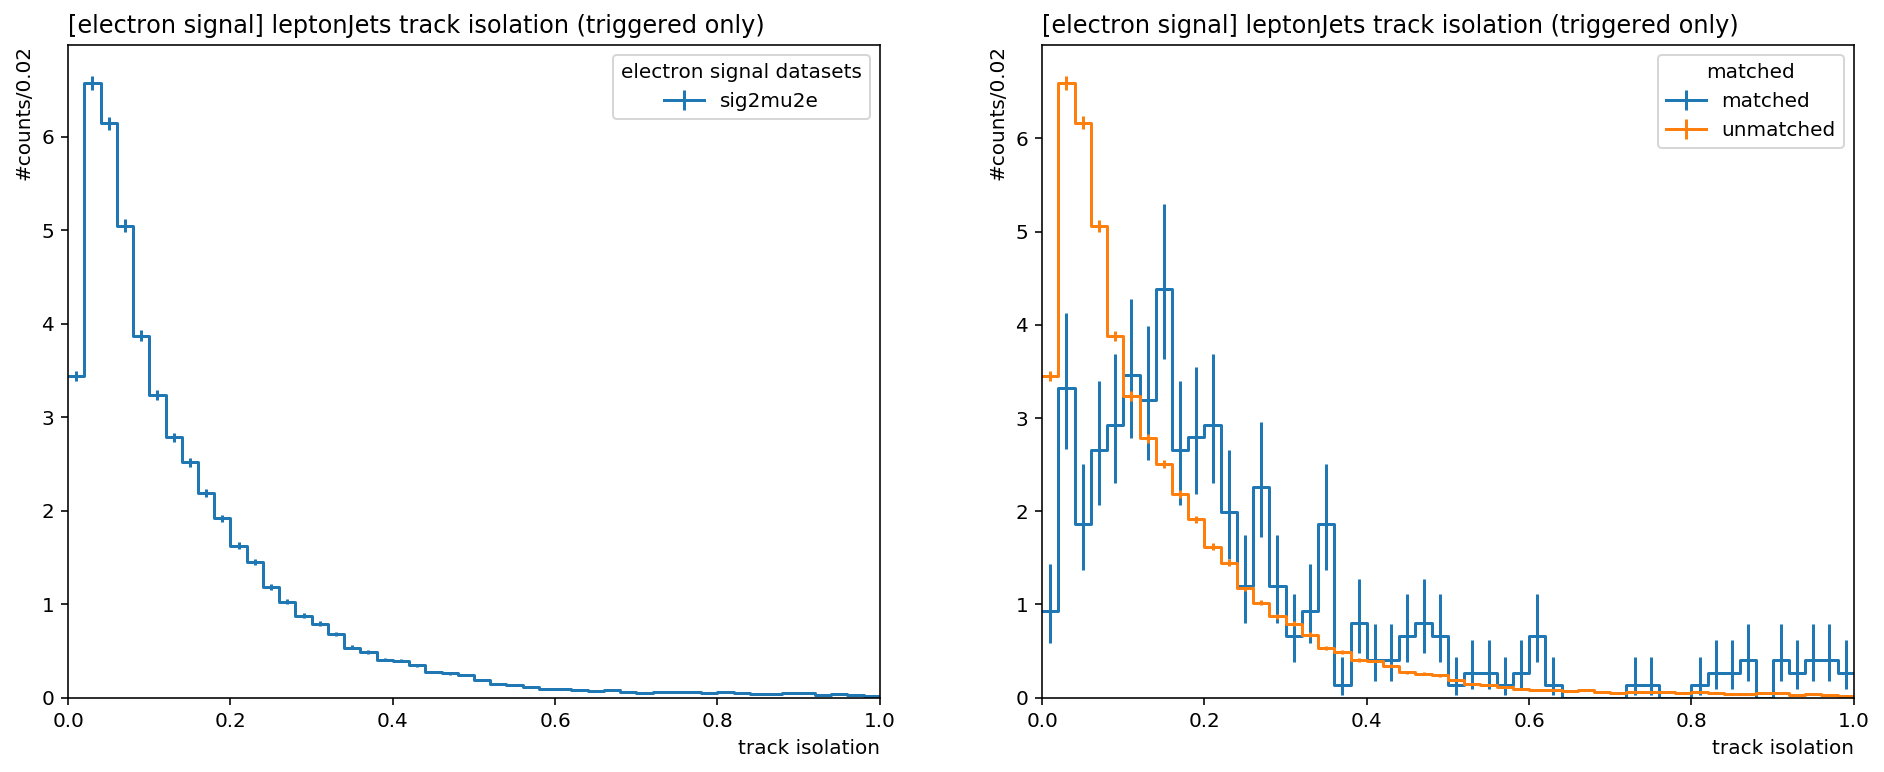

In [54]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['tkiso'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['tkiso'].project('dataset'), overlay='match', ax=axes[1], density=True)

for ax in axes:
    ax.set_title('[electron signal] leptonJets track isolation (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

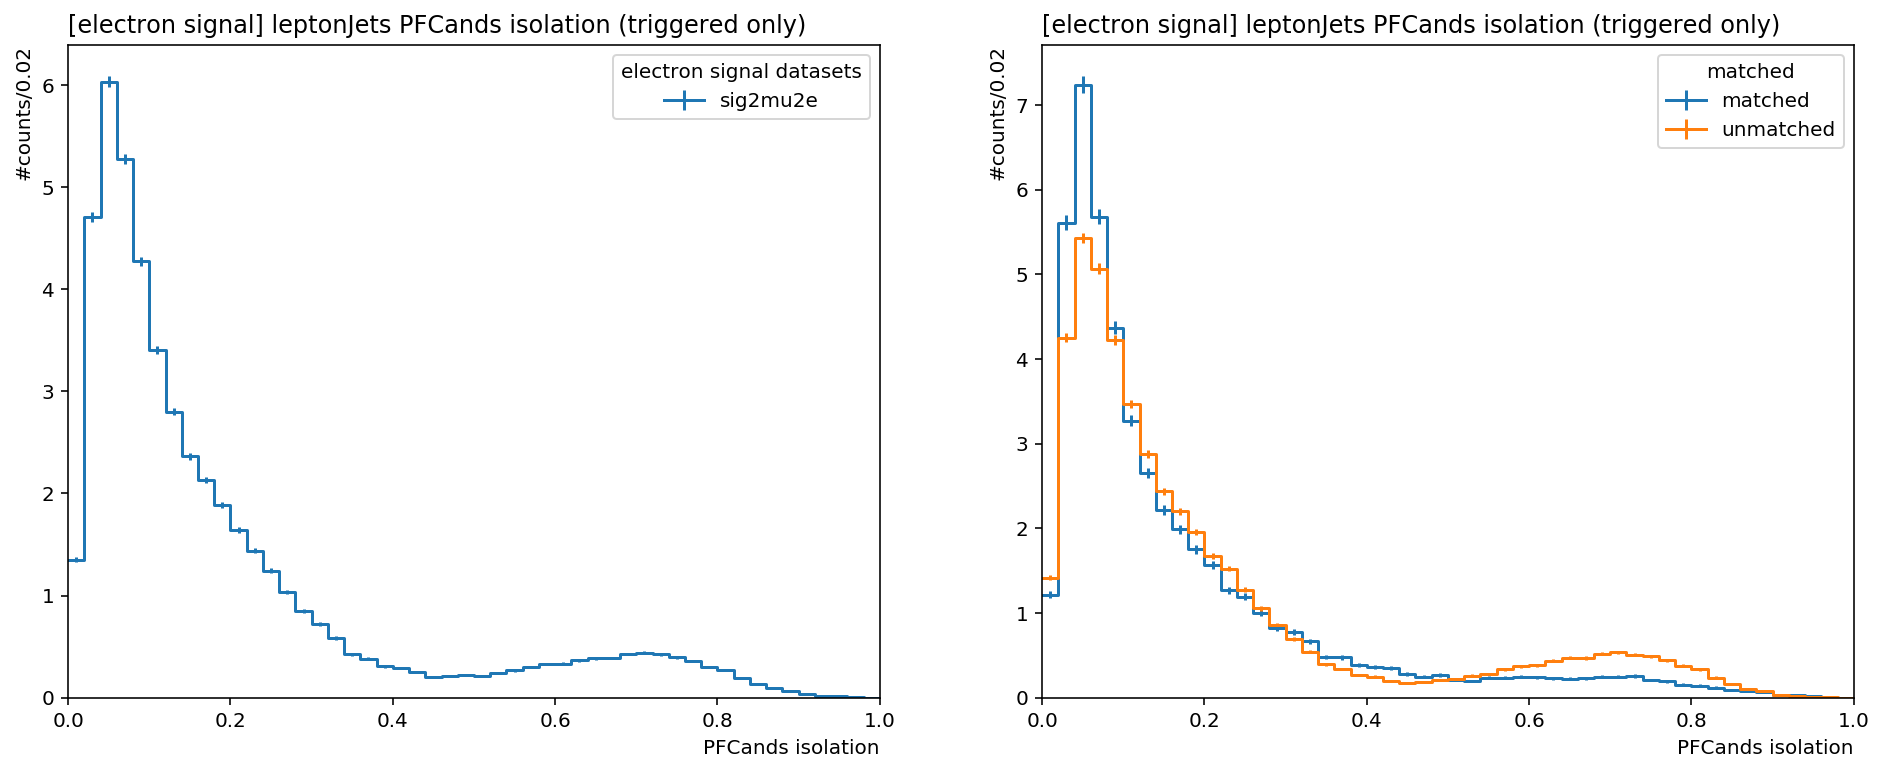

In [55]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['pfiso'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['pfiso'].project('dataset'), overlay='match', ax=axes[1], density=True)

for ax in axes:
    ax.set_title('[electron signal] leptonJets PFCands isolation (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

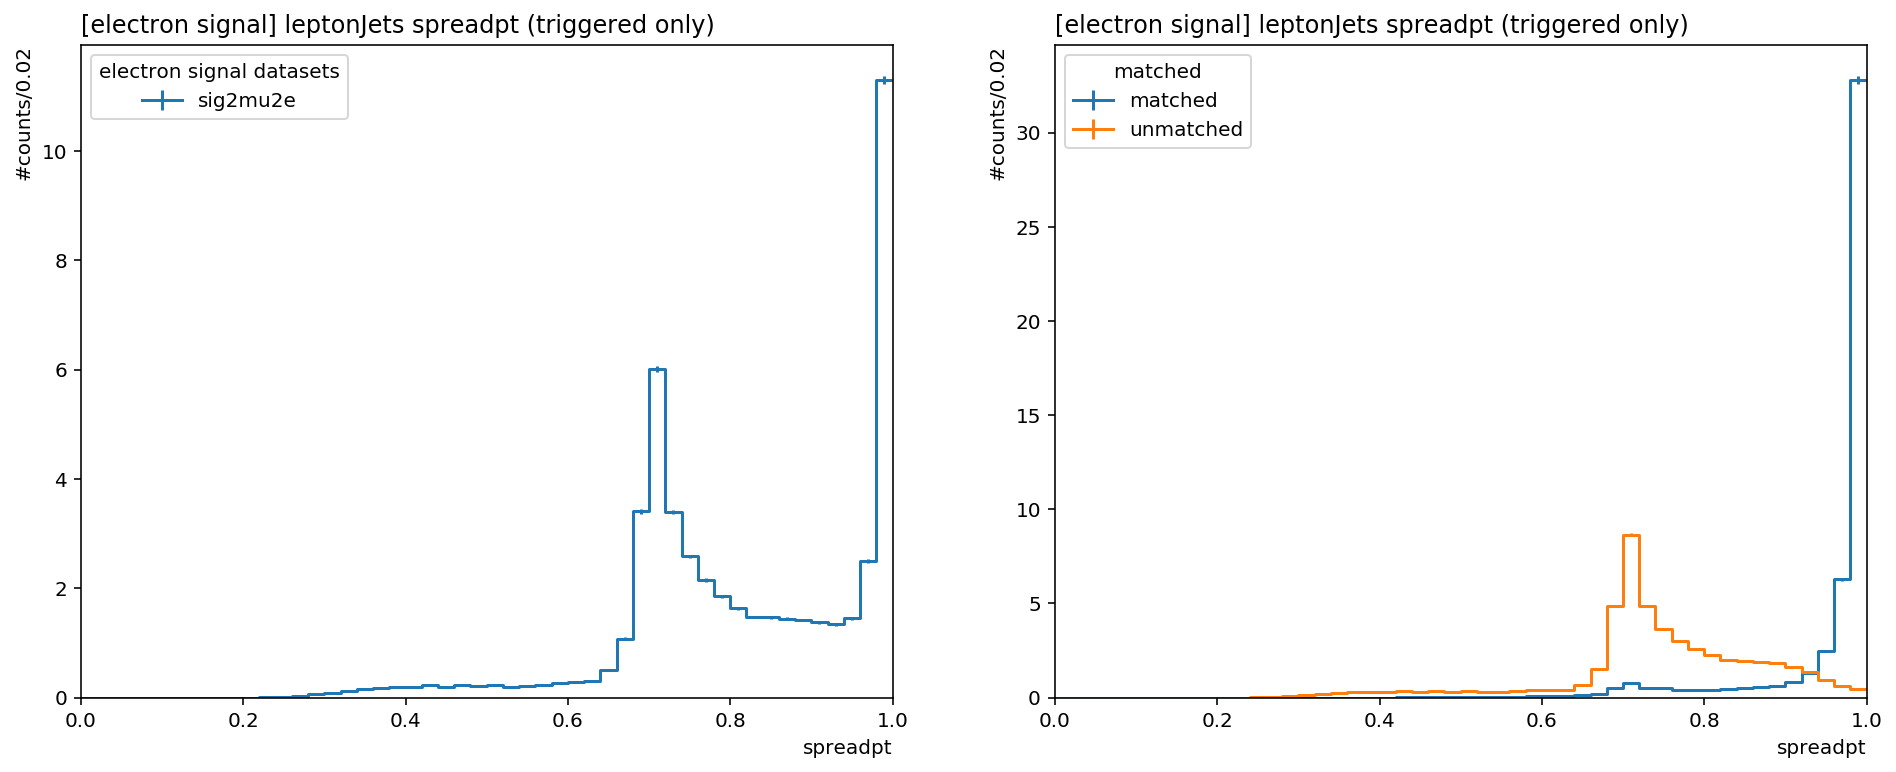

In [56]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['spreadpt'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['spreadpt'].project('dataset'), overlay='match', ax=axes[1], density=True)

for ax in axes:
    ax.set_title('[electron signal] leptonJets spreadpt (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

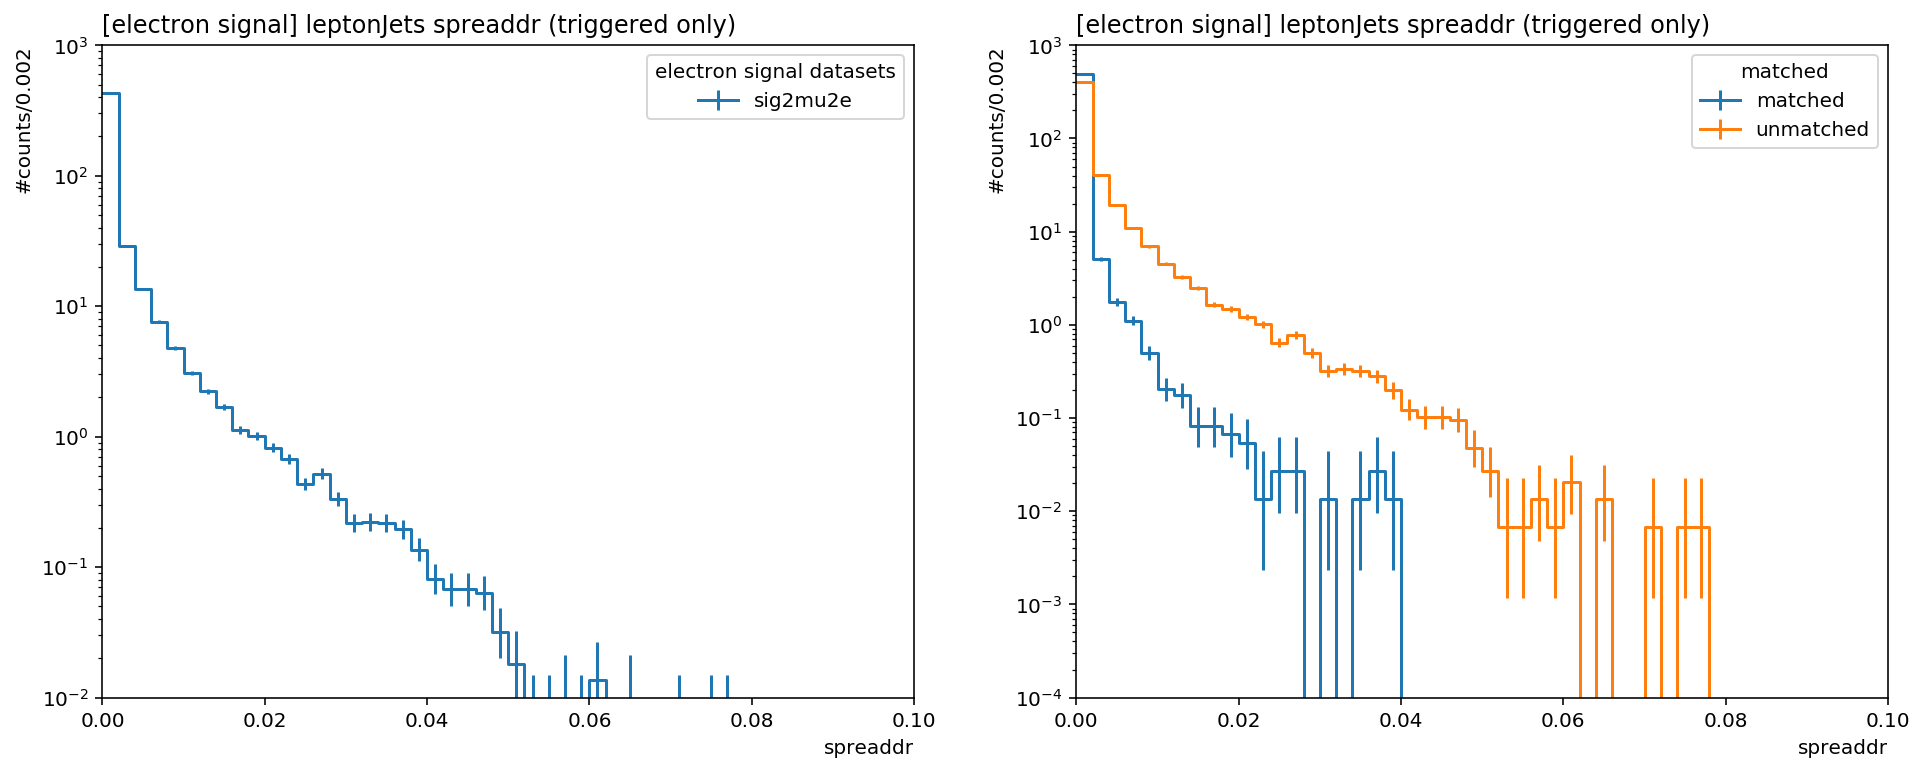

In [57]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['spreaddr'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['spreaddr'].project('dataset'), overlay='match', ax=axes[1], density=True)
axes[0].set_ylim([1e-2, 1e3])
axes[1].set_ylim([1e-4, 1e3])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[electron signal] leptonJets spreaddr (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

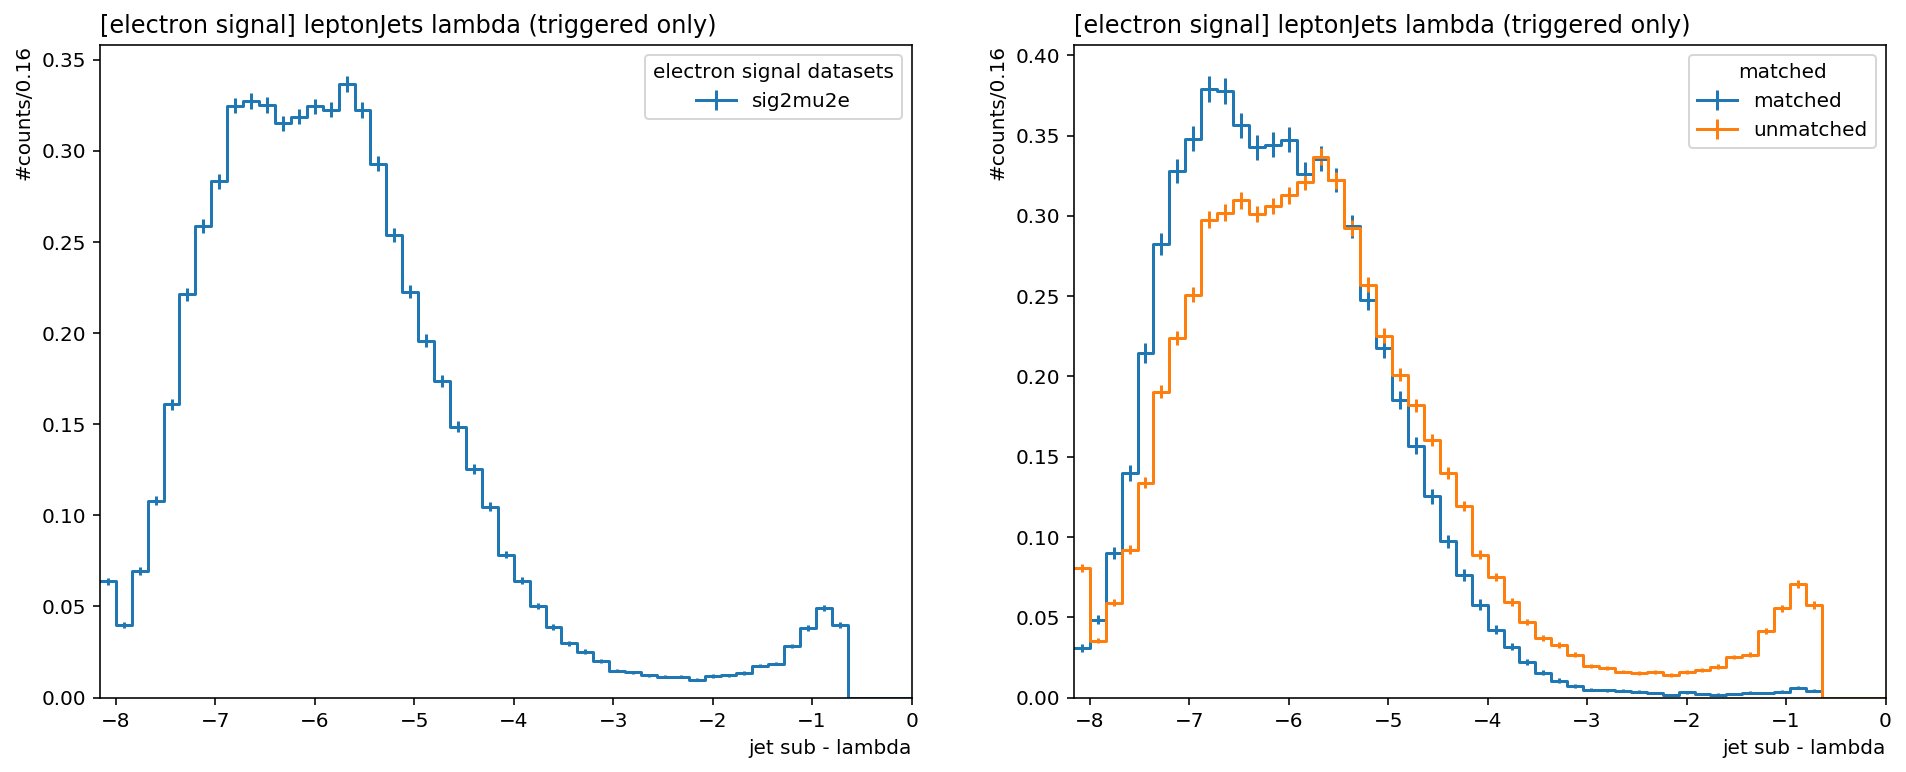

In [58]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['lamb'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='under')
fig, ax, _ = hist.plot1d(output['lamb'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='under')

for ax in axes:
    ax.set_title('[electron signal] leptonJets lambda (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

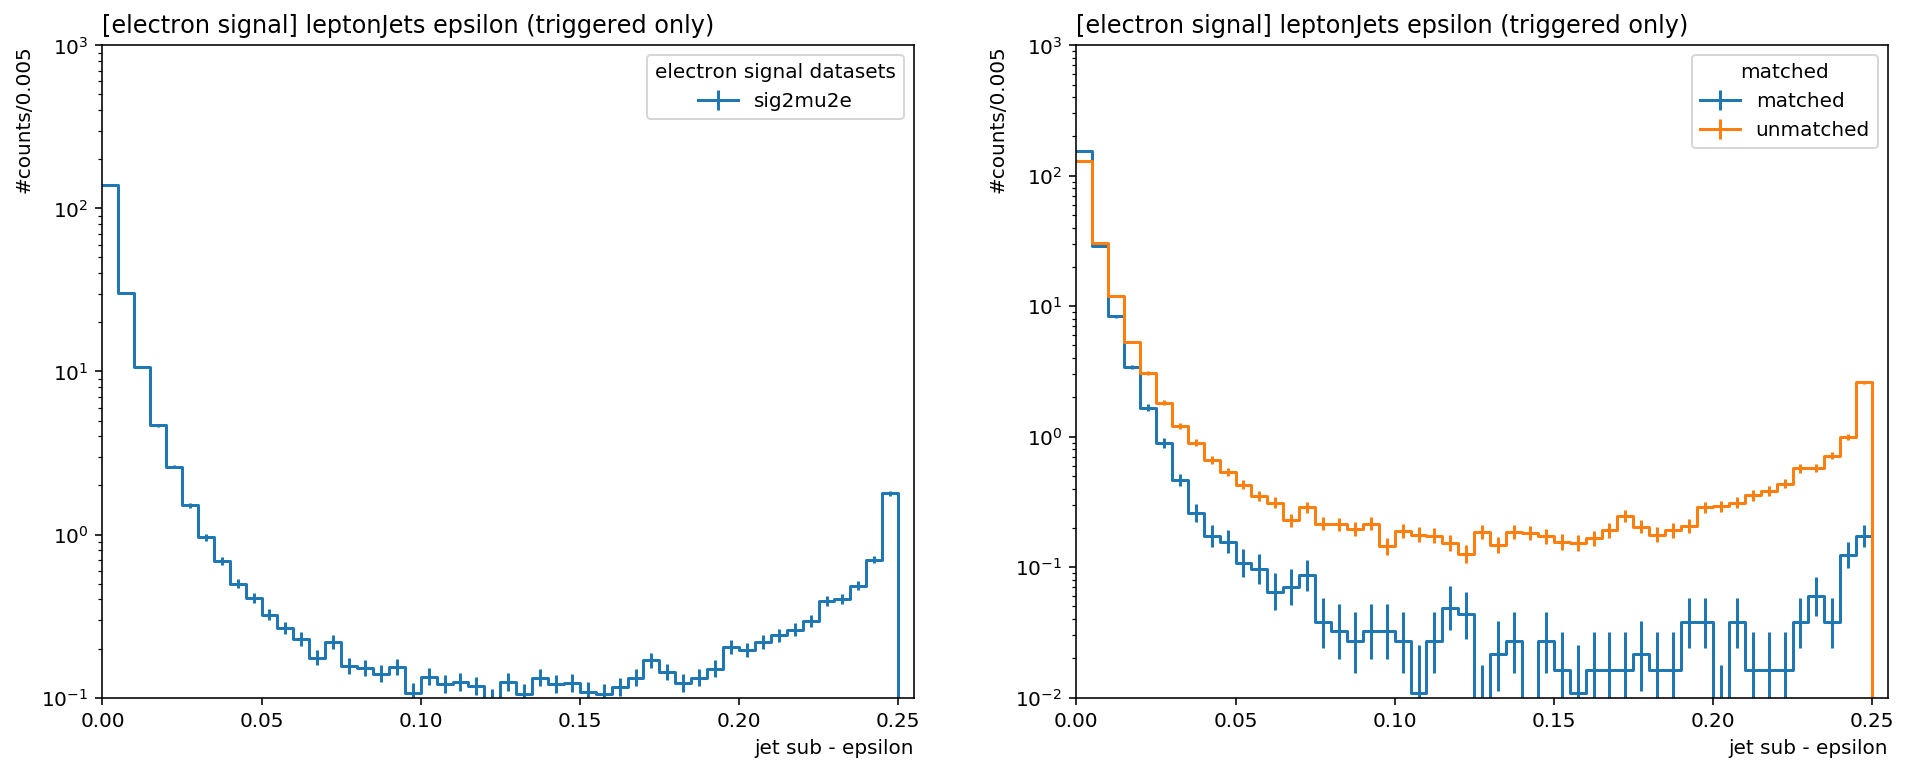

In [59]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['epsi'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='over')
fig, ax, _ = hist.plot1d(output['epsi'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='over')
axes[0].set_ylim([1e-1, 1e3])
axes[1].set_ylim([1e-2, 1e3])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[electron signal] leptonJets epsilon (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

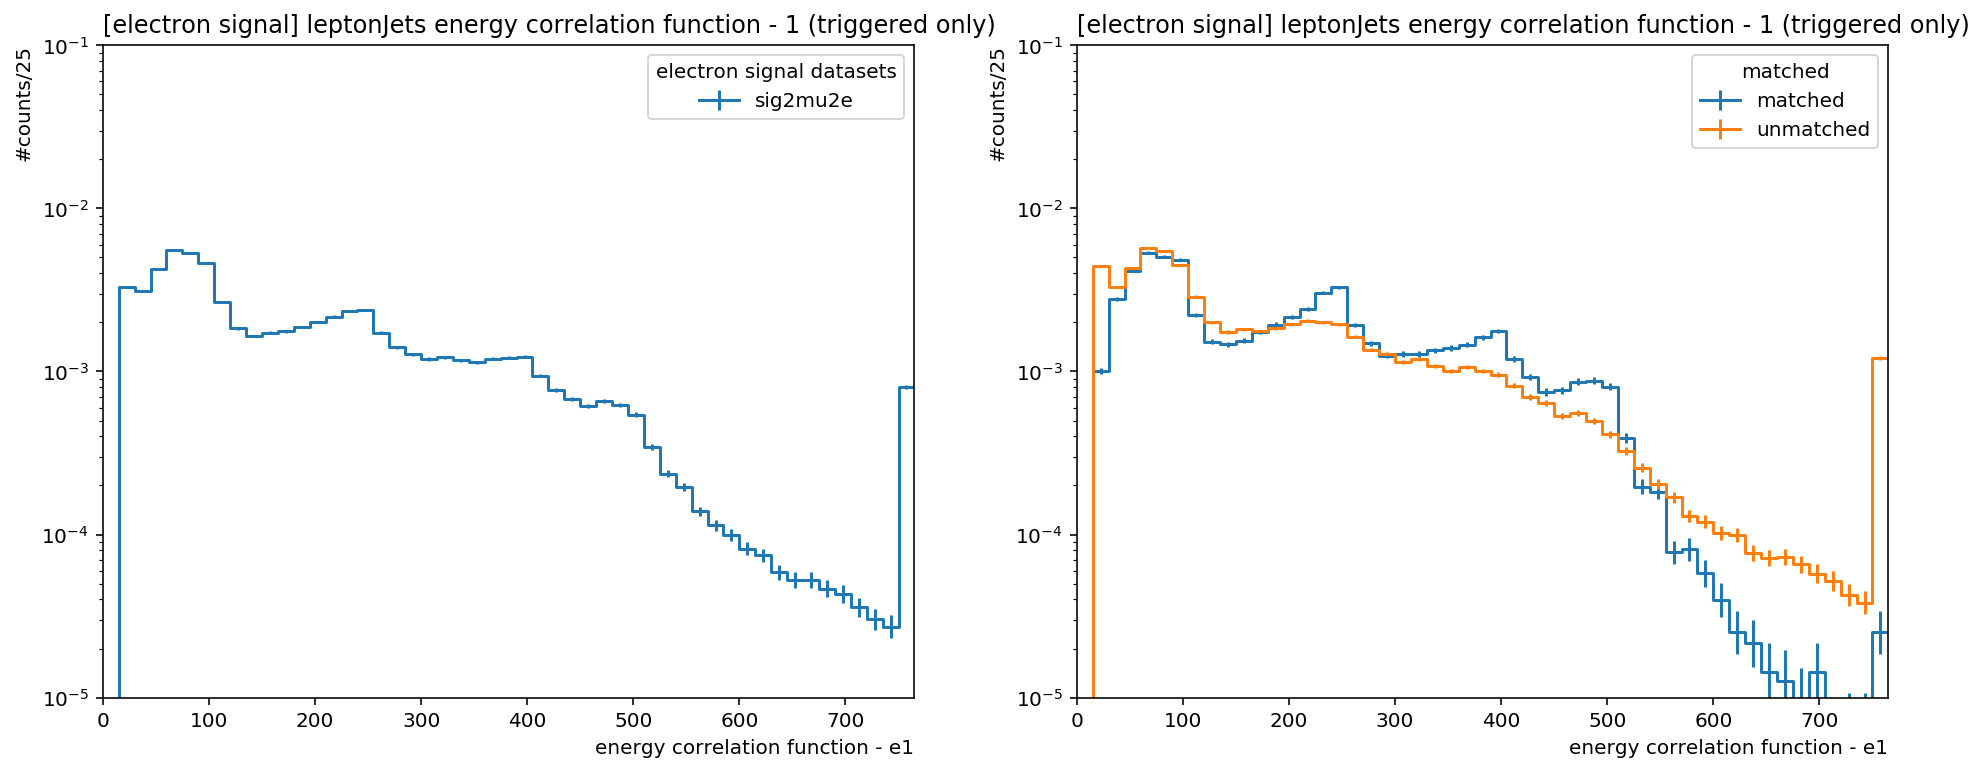

In [60]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['ecfe1'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='over')
fig, ax, _ = hist.plot1d(output['ecfe1'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='over')

for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim([1e-5, 1e-1])
    ax.set_title('[electron signal] leptonJets energy correlation function - 1 (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

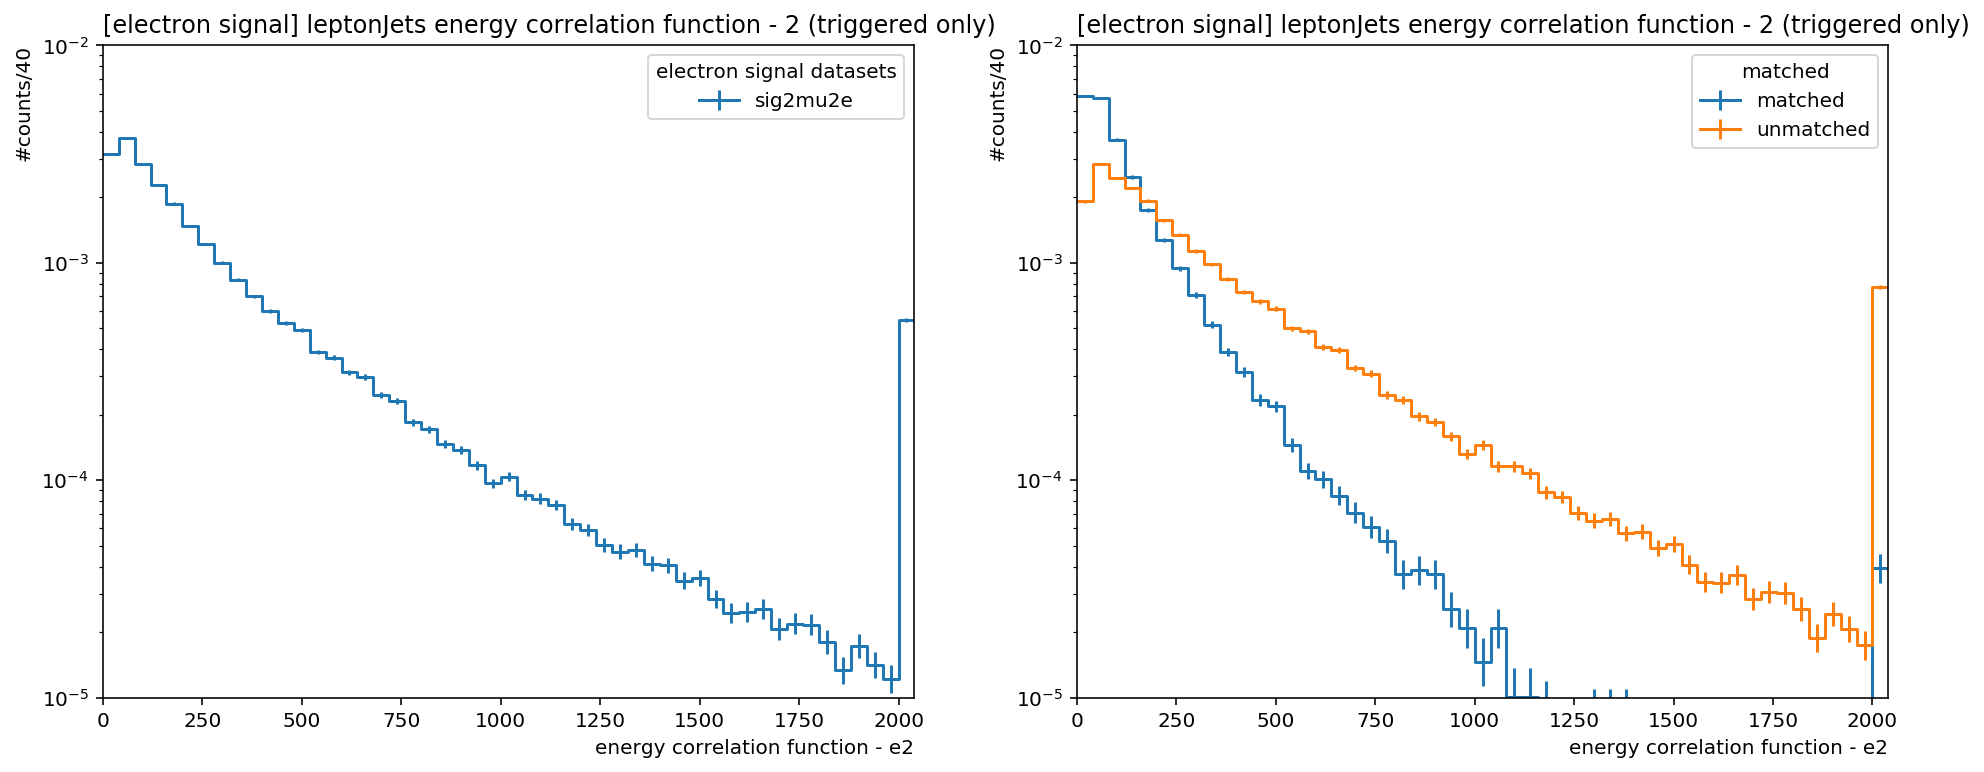

In [61]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['ecfe2'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='over')
fig, ax, _ = hist.plot1d(output['ecfe2'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='over')

for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim([1e-5, 1e-2])
    ax.set_title('[electron signal] leptonJets energy correlation function - 2 (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

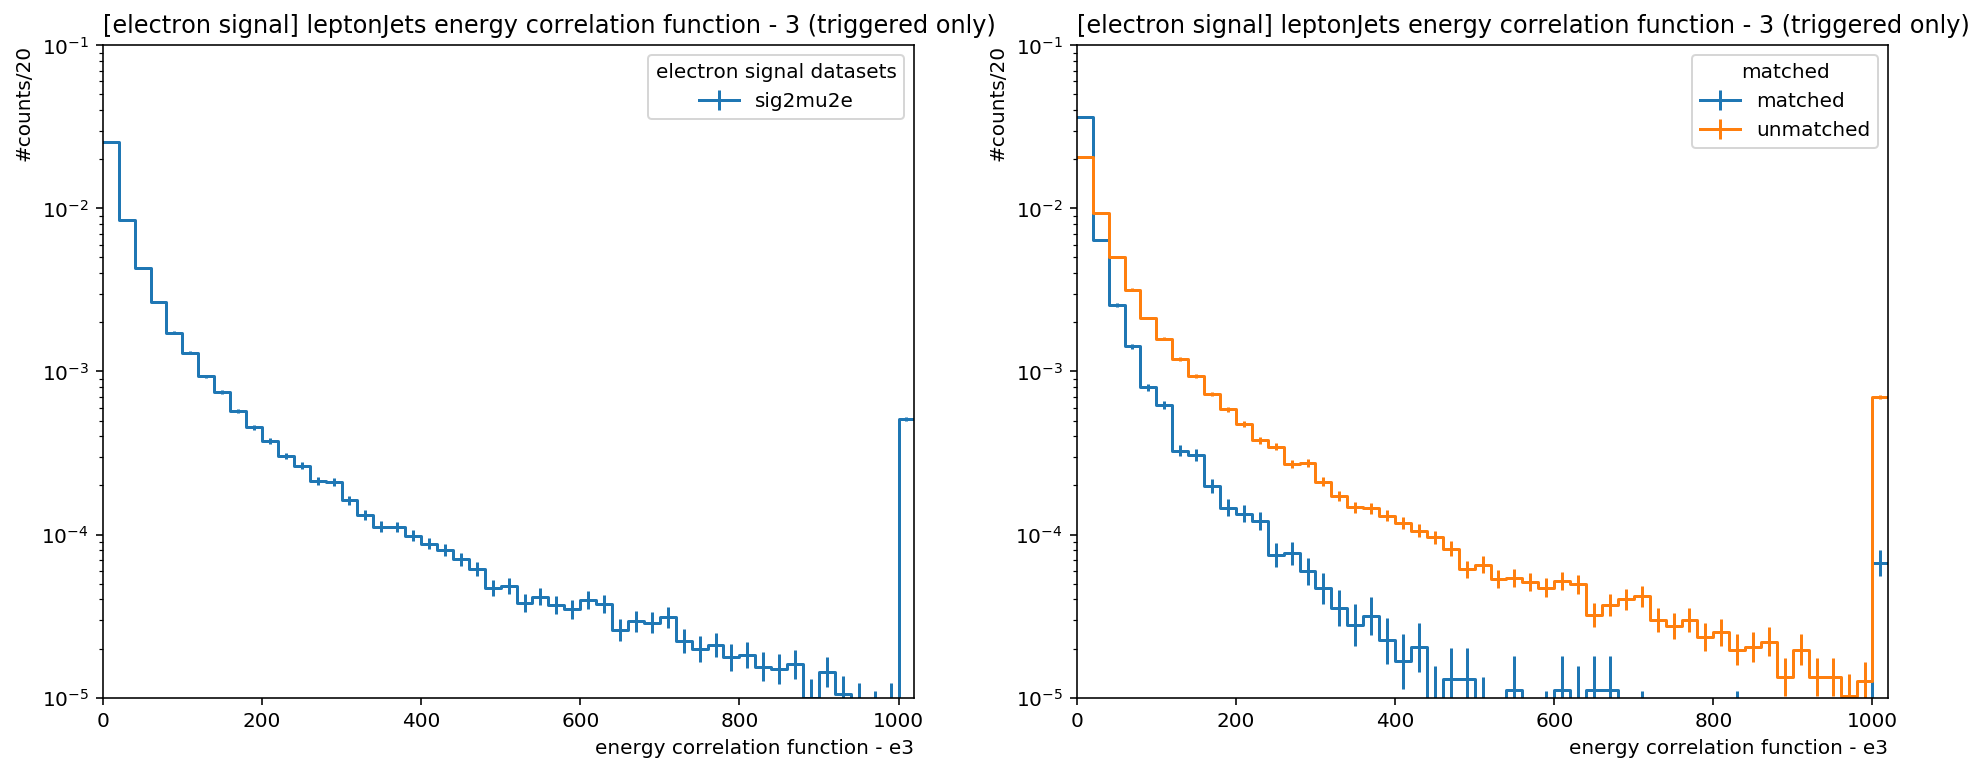

In [62]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['ecfe3'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='over')
fig, ax, _ = hist.plot1d(output['ecfe3'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='over')

for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim([1e-5, 1e-1])
    ax.set_title('[electron signal] leptonJets energy correlation function - 3 (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

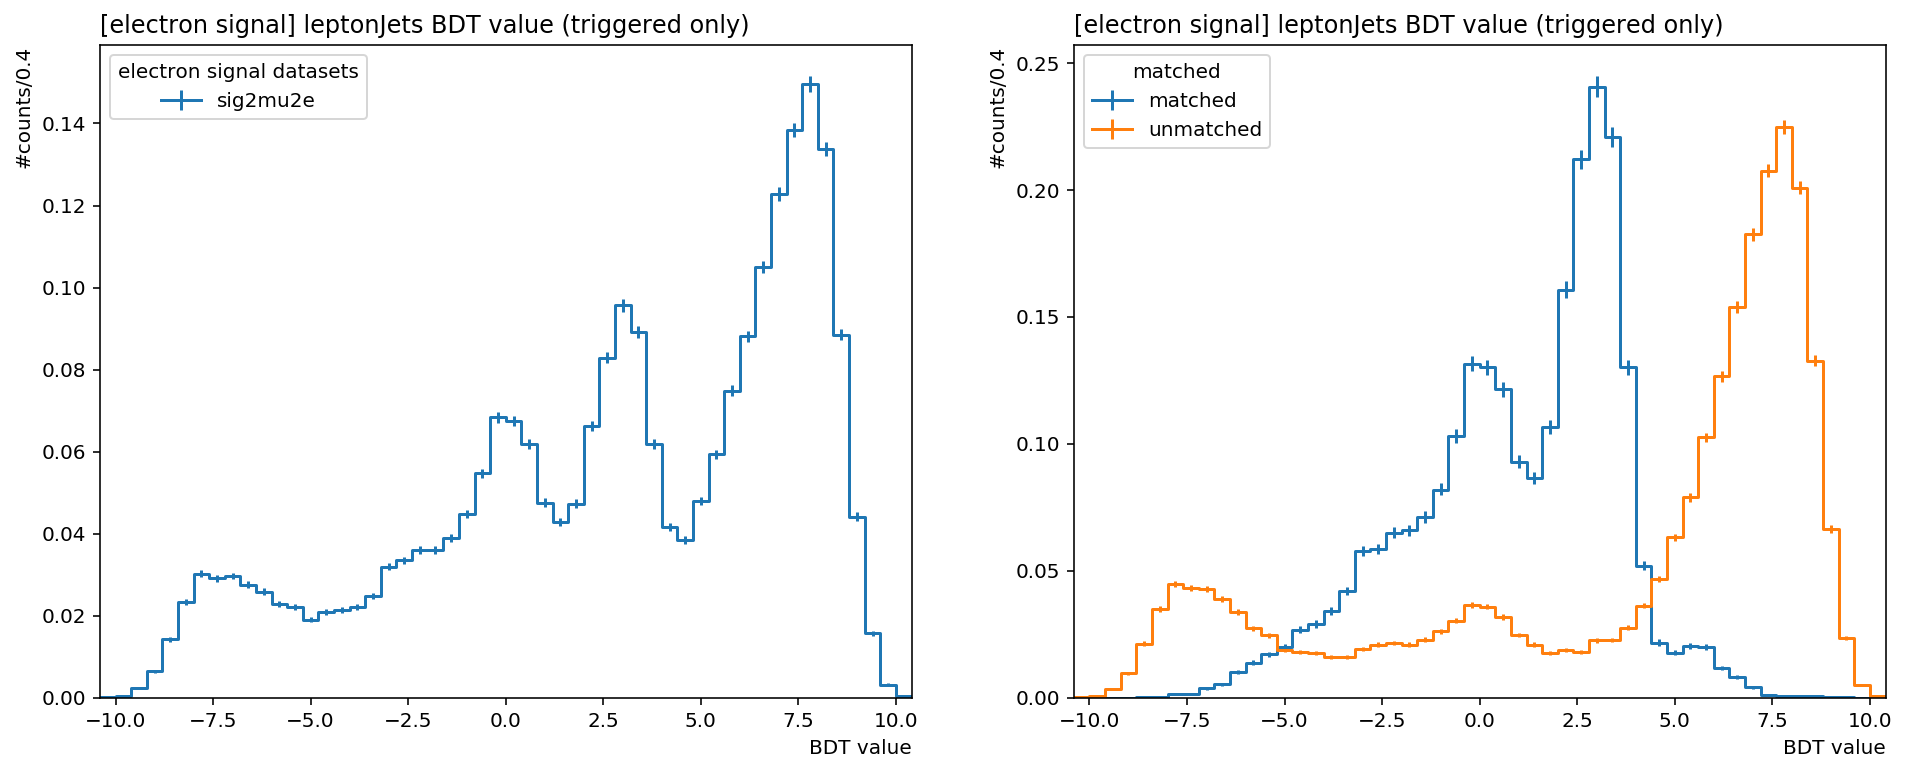

In [63]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['mva'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='all')
fig, ax, _ = hist.plot1d(output['mva'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='all')

for ax in axes:
    ax.set_title('[electron signal] leptonJets BDT value (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

In [34]:
class MuonLeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'muon signal datasets')
        match_axis   = hist.Cat('match', 'matched')
        pt_axis       = hist.Bin("pt", "pT [GeV]", 50, 0, 800)
        eta_axis      = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        nef_axis      = hist.Bin("nef", "neutral energy fraction", 50, 0, 1)
        maxd0_axis    = hist.Bin("maxd0", 'track max |d0|', 50, 0, 0.5)
        mind0_axis    = hist.Bin("mind0", 'track min |d0|', 50, 0, 0.5)
        tkiso_axis    = hist.Bin('tkiso', 'track isolation', 50, 0, 1)
        pfiso_axis    = hist.Bin("pfiso", "PFCands isolation", 50, 0, 1)
        spreadpt_axis = hist.Bin("spreadpt", "spreadpt", 50, 0, 1)
        spreaddr_axis = hist.Bin("spreaddr", "spreaddr", 50, 0, 0.1)
        lambda_axis   = hist.Bin('lamb', 'jet sub - lambda', 50, -8, 0)
        epsilon_axis  = hist.Bin('epsi', 'jet sub - epsilon', 50, 0, 0.25)
        ecfe1_axis    = hist.Bin('ecfe1', 'energy correlation function - e1', 50, 0, 750)
        ecfe2_axis    = hist.Bin('ecfe2', 'energy correlation function - e2', 50, 0, 2000)
        ecfe3_axis    = hist.Bin('ecfe3', 'energy correlation function - e3', 50, 0, 1000)
        mva_axis      = hist.Bin('mva', 'BDT value', 50, -10, 10)
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("#counts/16GeV", dataset_axis, pt_axis, match_axis),
            "eta": hist.Hist("#counts/0.096", dataset_axis, eta_axis, match_axis),
            "nef": hist.Hist("#counts/0.02", dataset_axis, nef_axis, match_axis),
            "maxd0": hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis, match_axis),
            "mind0": hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis, match_axis),
            "tkiso": hist.Hist("#counts/0.02", dataset_axis, tkiso_axis, match_axis),
            "pfiso": hist.Hist("#counts/0.02", dataset_axis, pfiso_axis, match_axis),
            "spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis, match_axis),
            "spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis, match_axis),
            "lamb": hist.Hist("#counts/0.16", dataset_axis, lambda_axis, match_axis),
            "epsi": hist.Hist("#counts/0.005", dataset_axis, epsilon_axis, match_axis),
            "ecfe1": hist.Hist("#counts/25", dataset_axis, ecfe1_axis, match_axis),
            "ecfe2": hist.Hist("#counts/40", dataset_axis, ecfe2_axis, match_axis),
            "ecfe3": hist.Hist("#counts/20", dataset_axis, ecfe3_axis, match_axis),
            "mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis, match_axis),
        })

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        maxd0_ = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0).max()
        mind0_ = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0).min()
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            nef=(df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT'],
            maxd0=maxd0_.content,
            mind0=mind0_.content,
            tkiso=df['pfjet_tkIsolation05'],
            pfiso=df['pfjet_pfIsolation05'],
            spreadpt=df['pfjet_ptDistribution'],
            spreaddr=df['pfjet_dRSpread'],
            lamb=df['pfjet_subjet_lambda'],
            epsi=df['pfjet_subjet_epsilon'],
            ecf1=df['pfjet_subjet_ecf1'],
            ecf2=df['pfjet_subjet_ecf2'],
            ecf3=df['pfjet_subjet_ecf3'],
            mva=df['pfjet_mva'],
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid']
        )
        darkphotons = genparticles[genparticles.pid==32]
        photonmatchmask = leptonjets.match(darkphotons, deltaRCut=0.3)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        
        leptonjets_t = leptonjets[photonmatchmask][metfiltermask&triggermask]
        leptonjets_f = leptonjets[~photonmatchmask][metfiltermask&triggermask]

        
        output['pt']      .fill(dataset=dataset, match='matched', pt=leptonjets_t.pt.flatten())
        output['eta']     .fill(dataset=dataset, match='matched', eta=leptonjets_t.eta.flatten())
        output['nef']     .fill(dataset=dataset, match='matched', nef=leptonjets_t.nef.flatten())
        output['maxd0']   .fill(dataset=dataset, match='matched', maxd0=leptonjets_t.maxd0.flatten())
        output['mind0']   .fill(dataset=dataset, match='matched', mind0=leptonjets_t.mind0.flatten())
        output['tkiso']   .fill(dataset=dataset, match='matched', tkiso=leptonjets_t.tkiso.flatten())
        output['pfiso']   .fill(dataset=dataset, match='matched', pfiso=leptonjets_t.pfiso.flatten())
        output['spreadpt'].fill(dataset=dataset, match='matched', spreadpt=leptonjets_t.spreadpt.flatten())
        output['spreaddr'].fill(dataset=dataset, match='matched', spreaddr=leptonjets_t.spreaddr.flatten())
        output['lamb']    .fill(dataset=dataset, match='matched', lamb=leptonjets_t.lamb.flatten())
        output['epsi']    .fill(dataset=dataset, match='matched', epsi=leptonjets_t.epsi.flatten())
        output['ecfe1']   .fill(dataset=dataset, match='matched', ecfe1=leptonjets_t.ecf1.flatten())
        output['ecfe2']   .fill(dataset=dataset, match='matched', ecfe2=leptonjets_t.ecf2.flatten())
        output['ecfe3']   .fill(dataset=dataset, match='matched', ecfe3=leptonjets_t.ecf3.flatten())
        output['mva']     .fill(dataset=dataset, match='matched', mva=leptonjets_t.mva.flatten())
        
        output['pt']      .fill(dataset=dataset, match='unmatched', pt=leptonjets_f.pt.flatten())
        output['eta']     .fill(dataset=dataset, match='unmatched', eta=leptonjets_f.eta.flatten())
        output['nef']     .fill(dataset=dataset, match='unmatched', nef=leptonjets_f.nef.flatten())
        output['maxd0']   .fill(dataset=dataset, match='unmatched', maxd0=leptonjets_f.maxd0.flatten())
        output['mind0']   .fill(dataset=dataset, match='unmatched', mind0=leptonjets_f.mind0.flatten())
        output['tkiso']   .fill(dataset=dataset, match='unmatched', tkiso=leptonjets_f.tkiso.flatten())
        output['pfiso']   .fill(dataset=dataset, match='unmatched', pfiso=leptonjets_f.pfiso.flatten())
        output['spreadpt'].fill(dataset=dataset, match='unmatched', spreadpt=leptonjets_f.spreadpt.flatten())
        output['spreaddr'].fill(dataset=dataset, match='unmatched', spreaddr=leptonjets_f.spreaddr.flatten())
        output['lamb']    .fill(dataset=dataset, match='unmatched', lamb=leptonjets_f.lamb.flatten())
        output['epsi']    .fill(dataset=dataset, match='unmatched', epsi=leptonjets_f.epsi.flatten())
        output['ecfe1']   .fill(dataset=dataset, match='unmatched', ecfe1=leptonjets_f.ecf1.flatten())
        output['ecfe2']   .fill(dataset=dataset, match='unmatched', ecfe2=leptonjets_f.ecf2.flatten())
        output['ecfe3']   .fill(dataset=dataset, match='unmatched', ecfe3=leptonjets_f.ecf3.flatten())
        output['mva']     .fill(dataset=dataset, match='unmatched', mva=leptonjets_f.mva.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [36]:
output = processor.run_uproot_job(mudataset,
                                  treename=None,
                                  processor_instance=MuonLeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 150/150 [00:17<00:00,  8.70items/s]


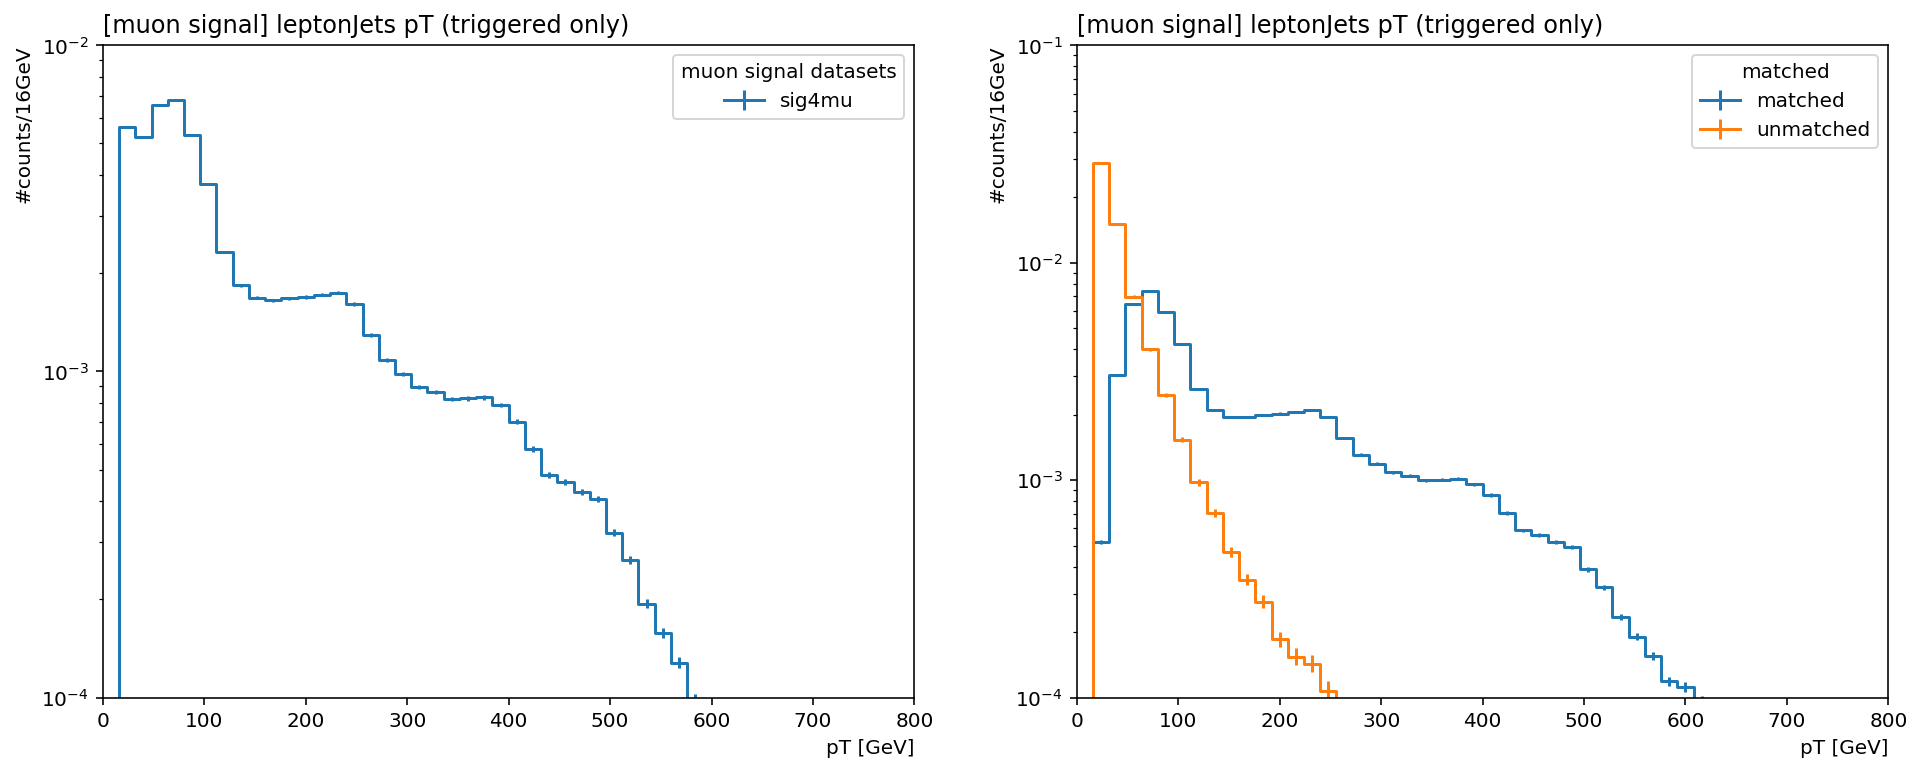

In [37]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['pt'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['pt'].project('dataset'), overlay='match', ax=axes[1], density=True)
axes[0].set_ylim([1e-4, 1e-2])
axes[1].set_ylim([1e-4, 1e-1])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[muon signal] leptonJets pT (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

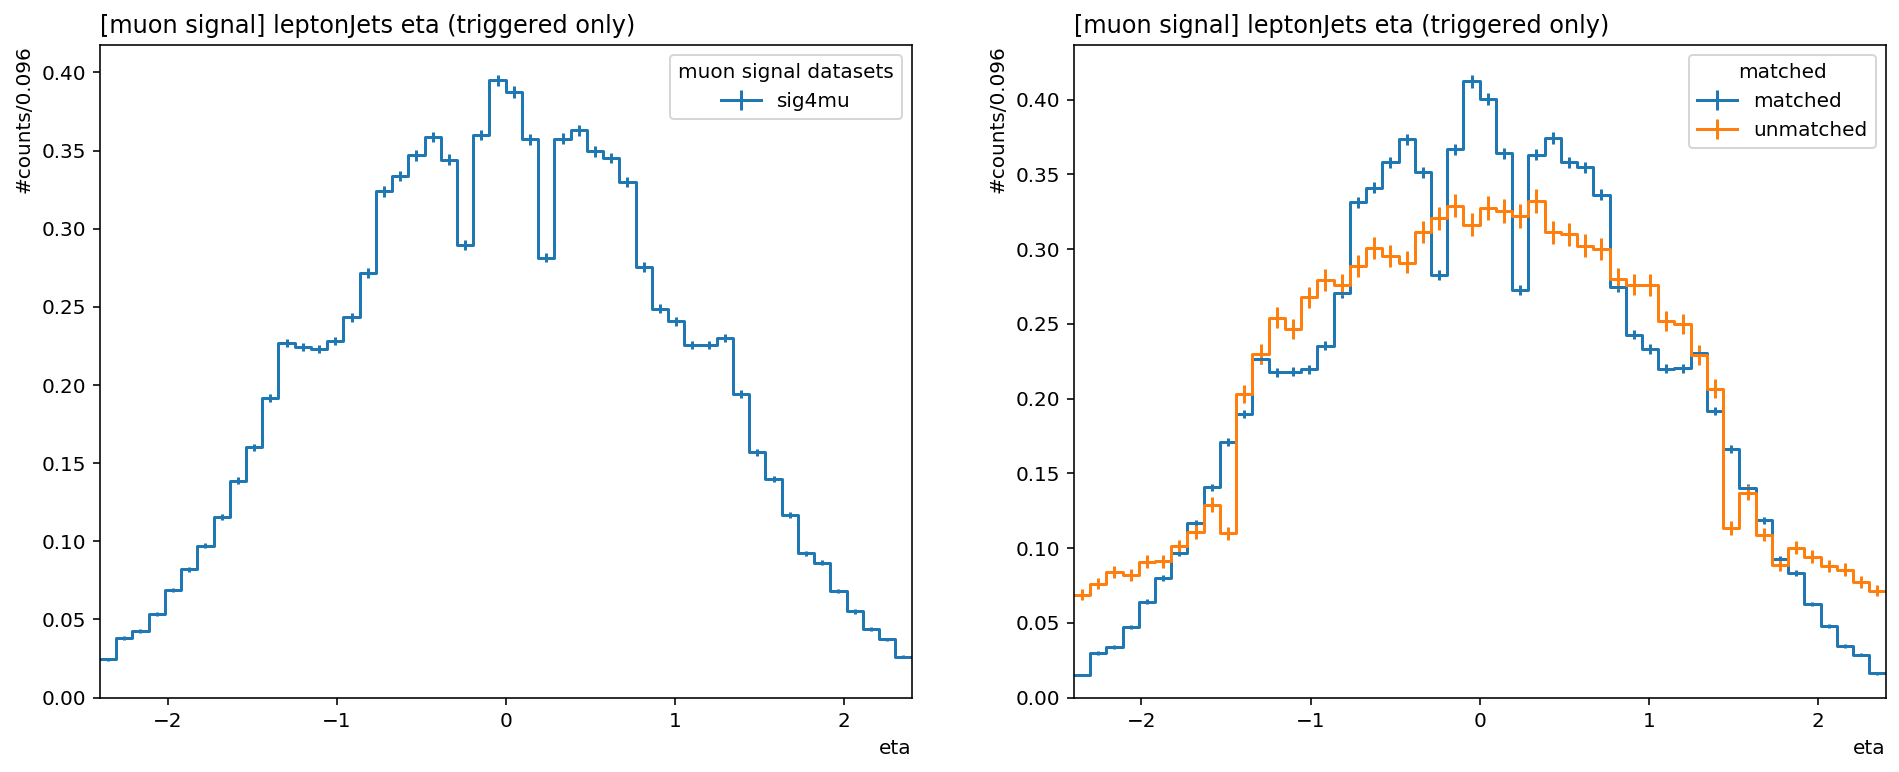

In [38]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['eta'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['eta'].project('dataset'), overlay='match', ax=axes[1], density=True)


for ax in axes:
    ax.set_title('[muon signal] leptonJets eta (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

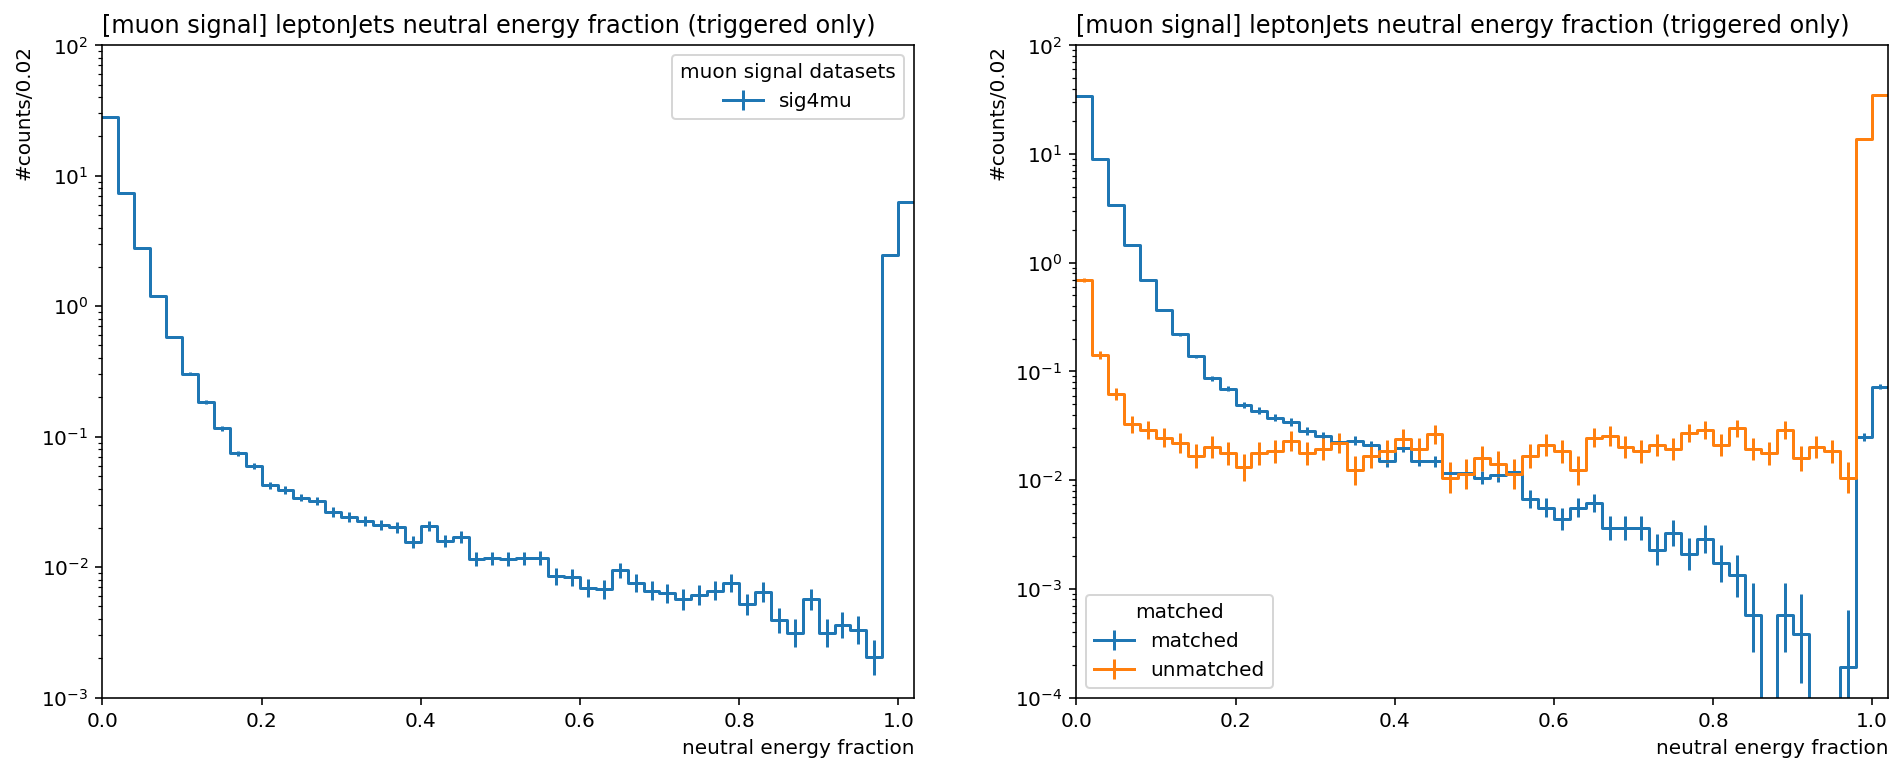

In [39]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['nef'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='over')
fig, ax, _ = hist.plot1d(output['nef'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='over')
axes[0].set_ylim([1e-3, 1e2])
axes[1].set_ylim([1e-4, 1e2])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[muon signal] leptonJets neutral energy fraction (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

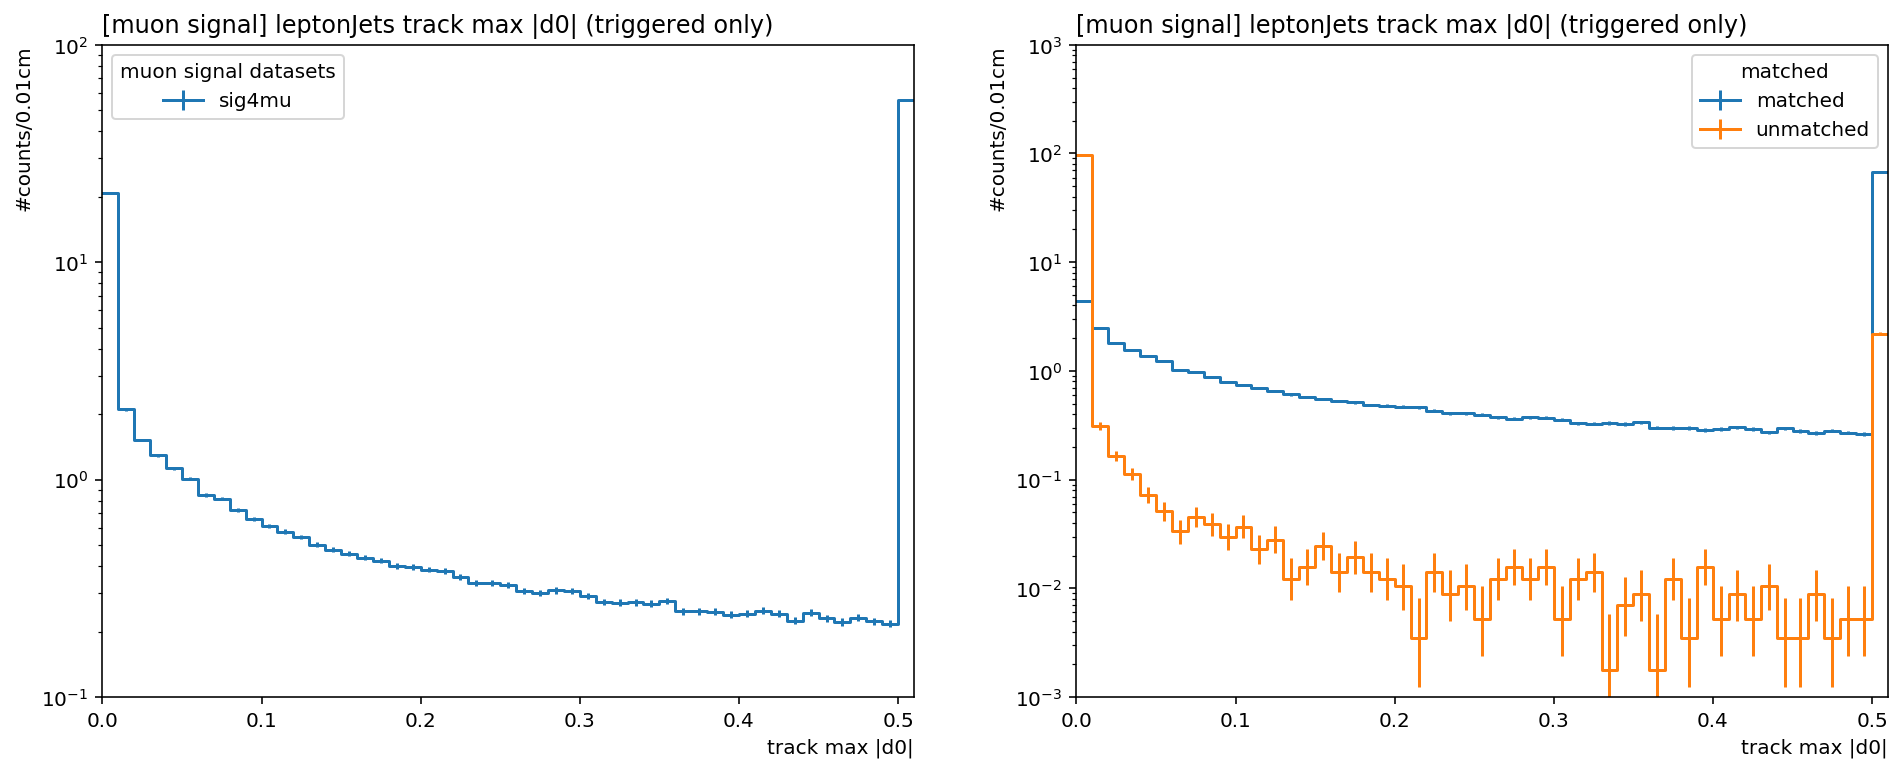

In [40]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['maxd0'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='over')
fig, ax, _ = hist.plot1d(output['maxd0'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='over')
axes[0].set_ylim([1e-1, 1e2])
axes[1].set_ylim([1e-3, 1e3])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[muon signal] leptonJets track max |d0| (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

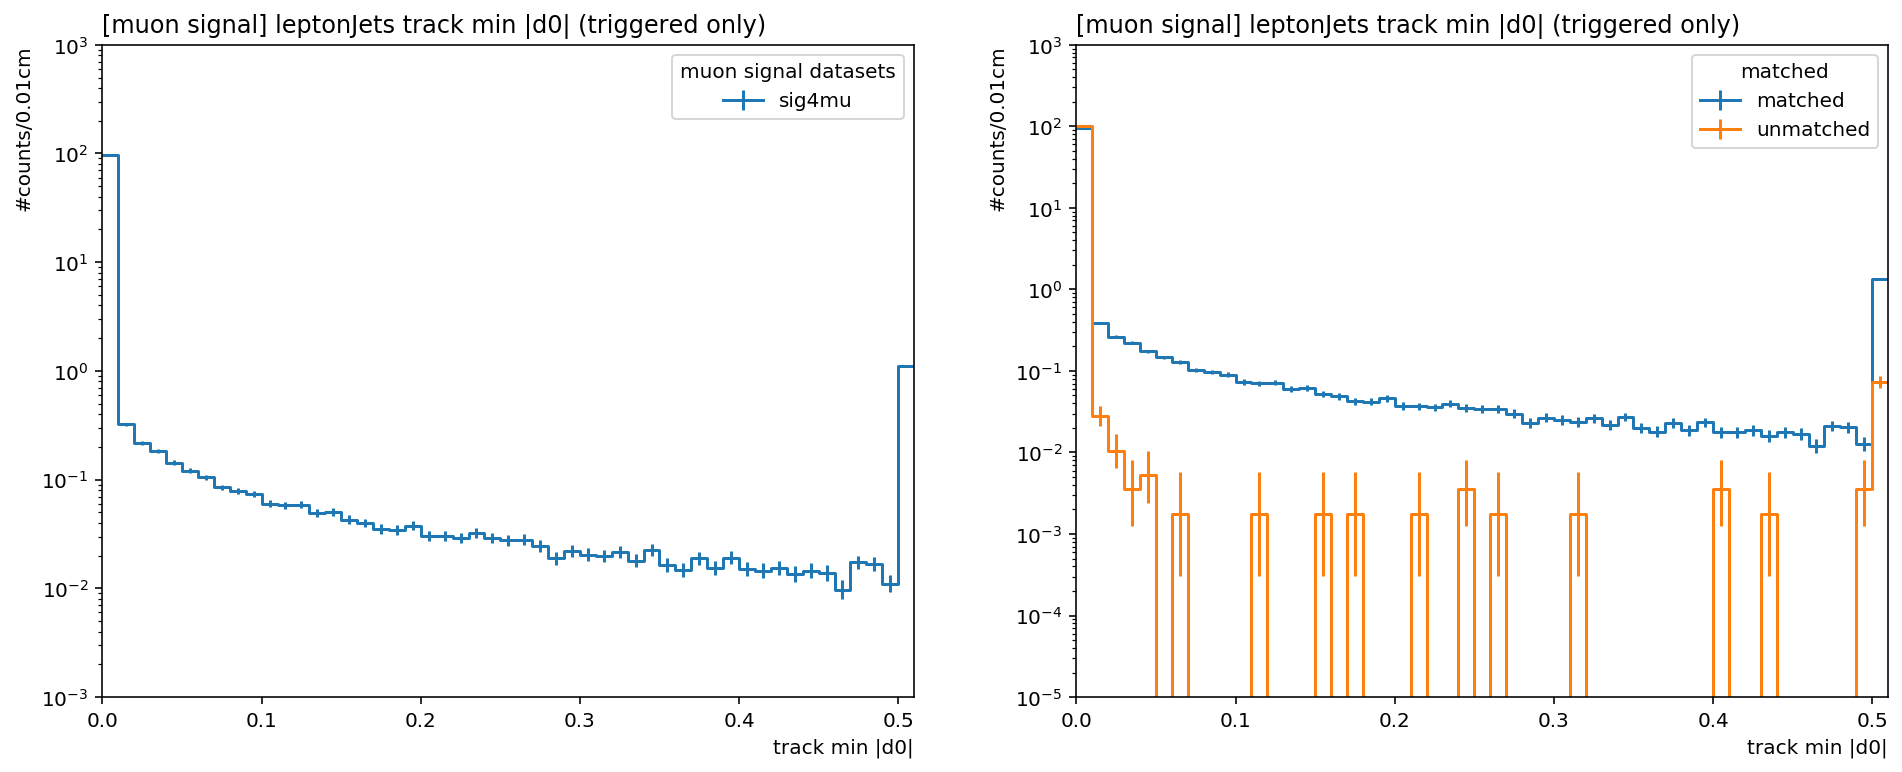

In [41]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['mind0'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='over')
fig, ax, _ = hist.plot1d(output['mind0'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='over')
axes[0].set_ylim([1e-3, 1e3])
axes[1].set_ylim([1e-5, 1e3])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[muon signal] leptonJets track min |d0| (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

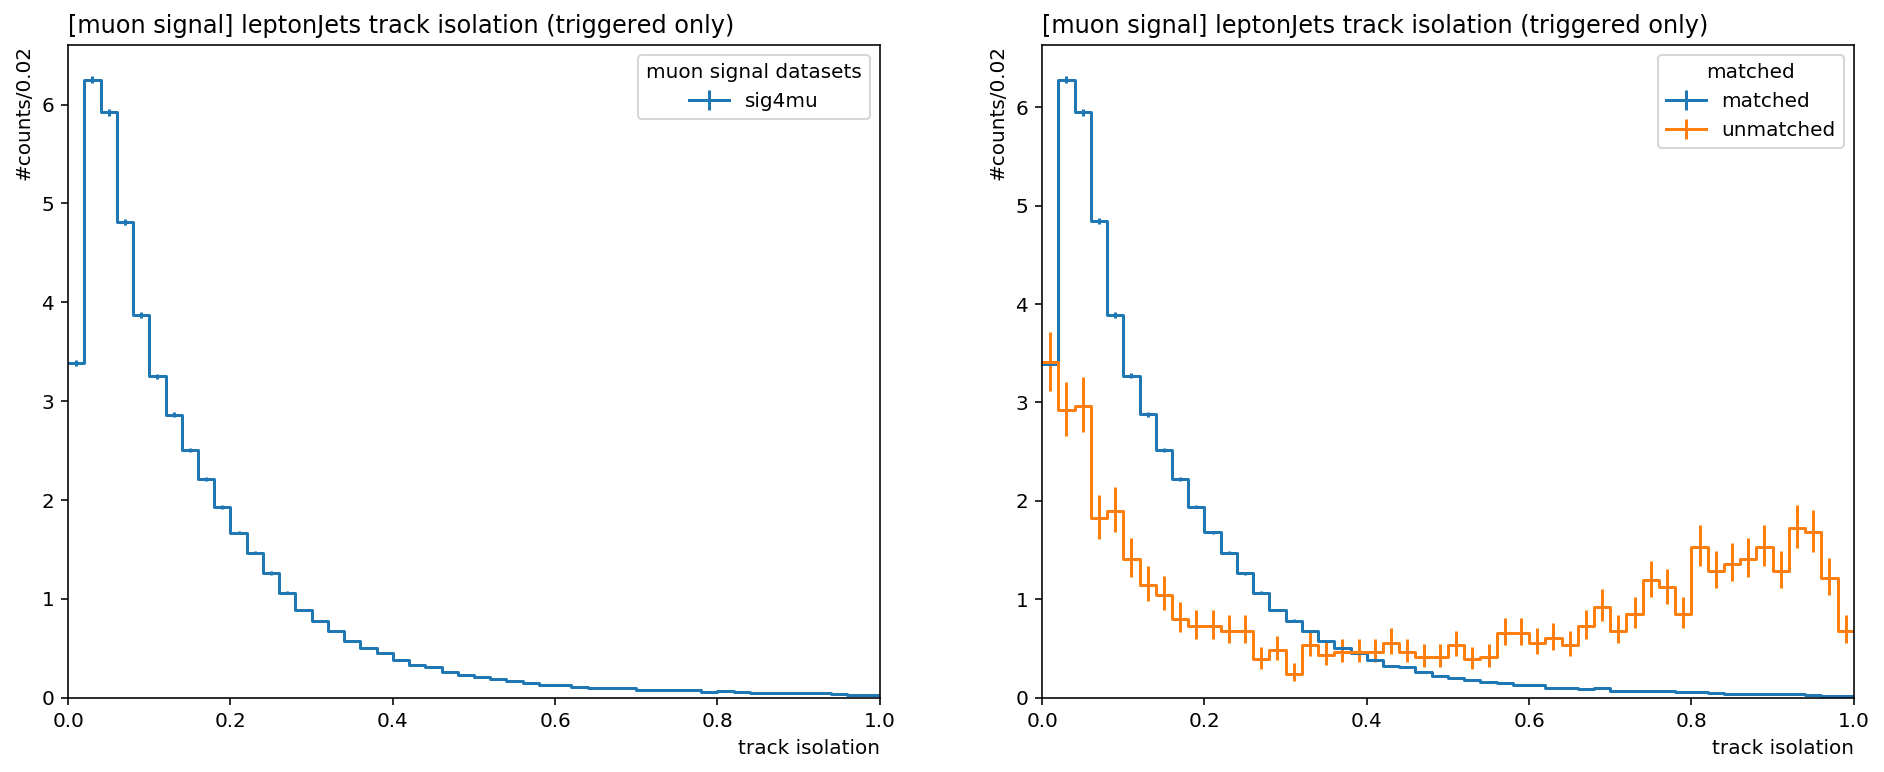

In [42]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['tkiso'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['tkiso'].project('dataset'), overlay='match', ax=axes[1], density=True)

for ax in axes:
    ax.set_title('[muon signal] leptonJets track isolation (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

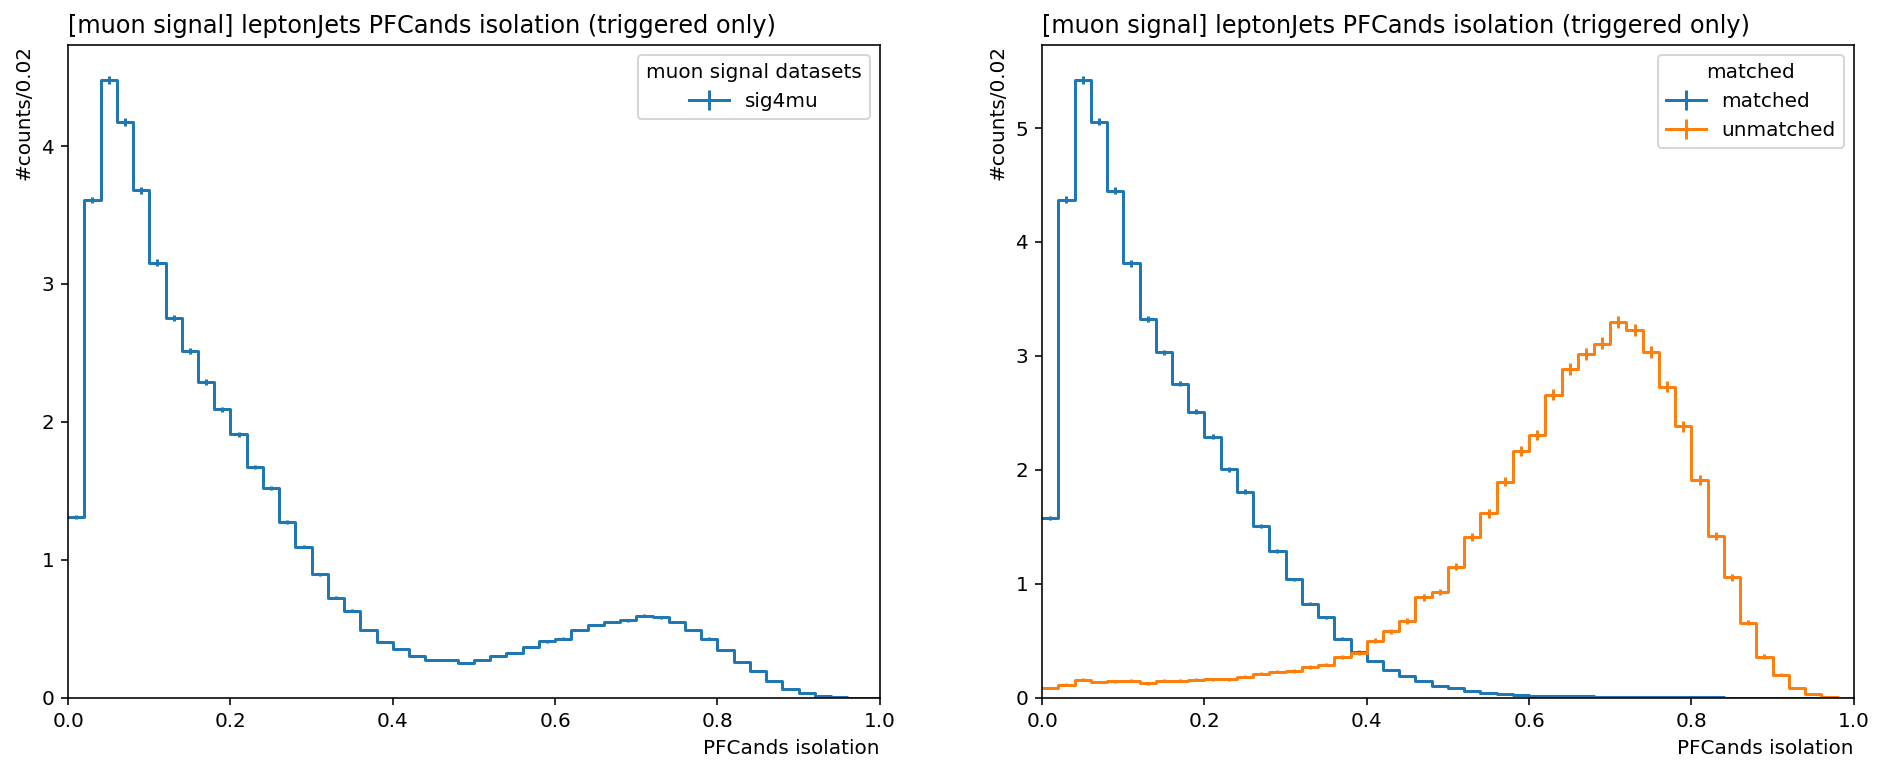

In [43]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['pfiso'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['pfiso'].project('dataset'), overlay='match', ax=axes[1], density=True)

for ax in axes:
    ax.set_title('[muon signal] leptonJets PFCands isolation (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

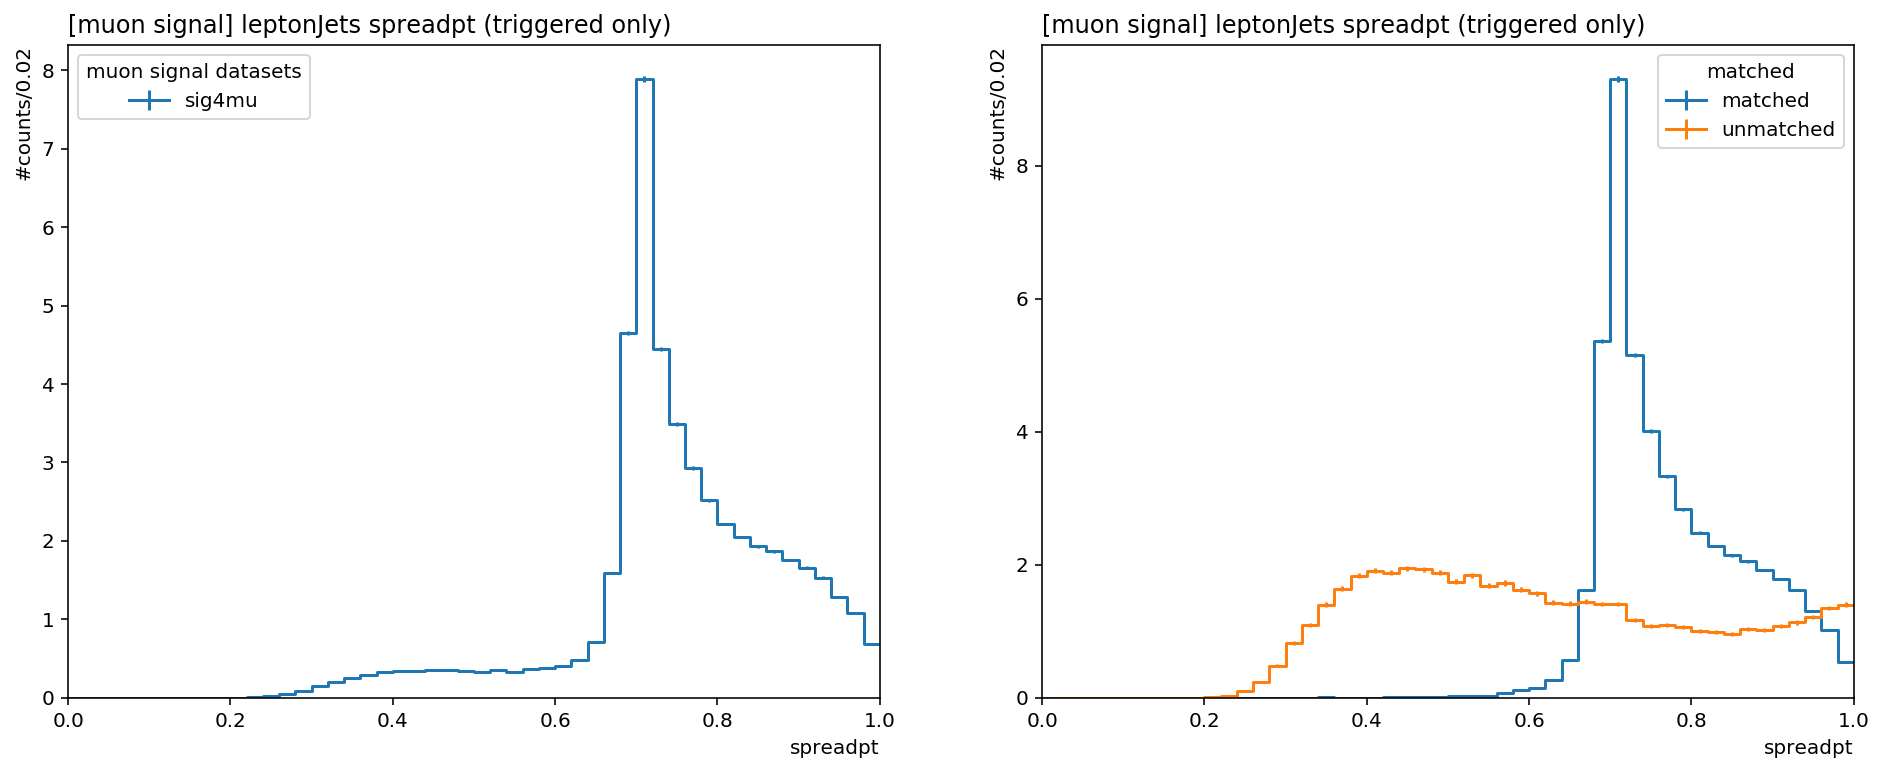

In [44]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['spreadpt'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['spreadpt'].project('dataset'), overlay='match', ax=axes[1], density=True)

for ax in axes:
    ax.set_title('[muon signal] leptonJets spreadpt (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

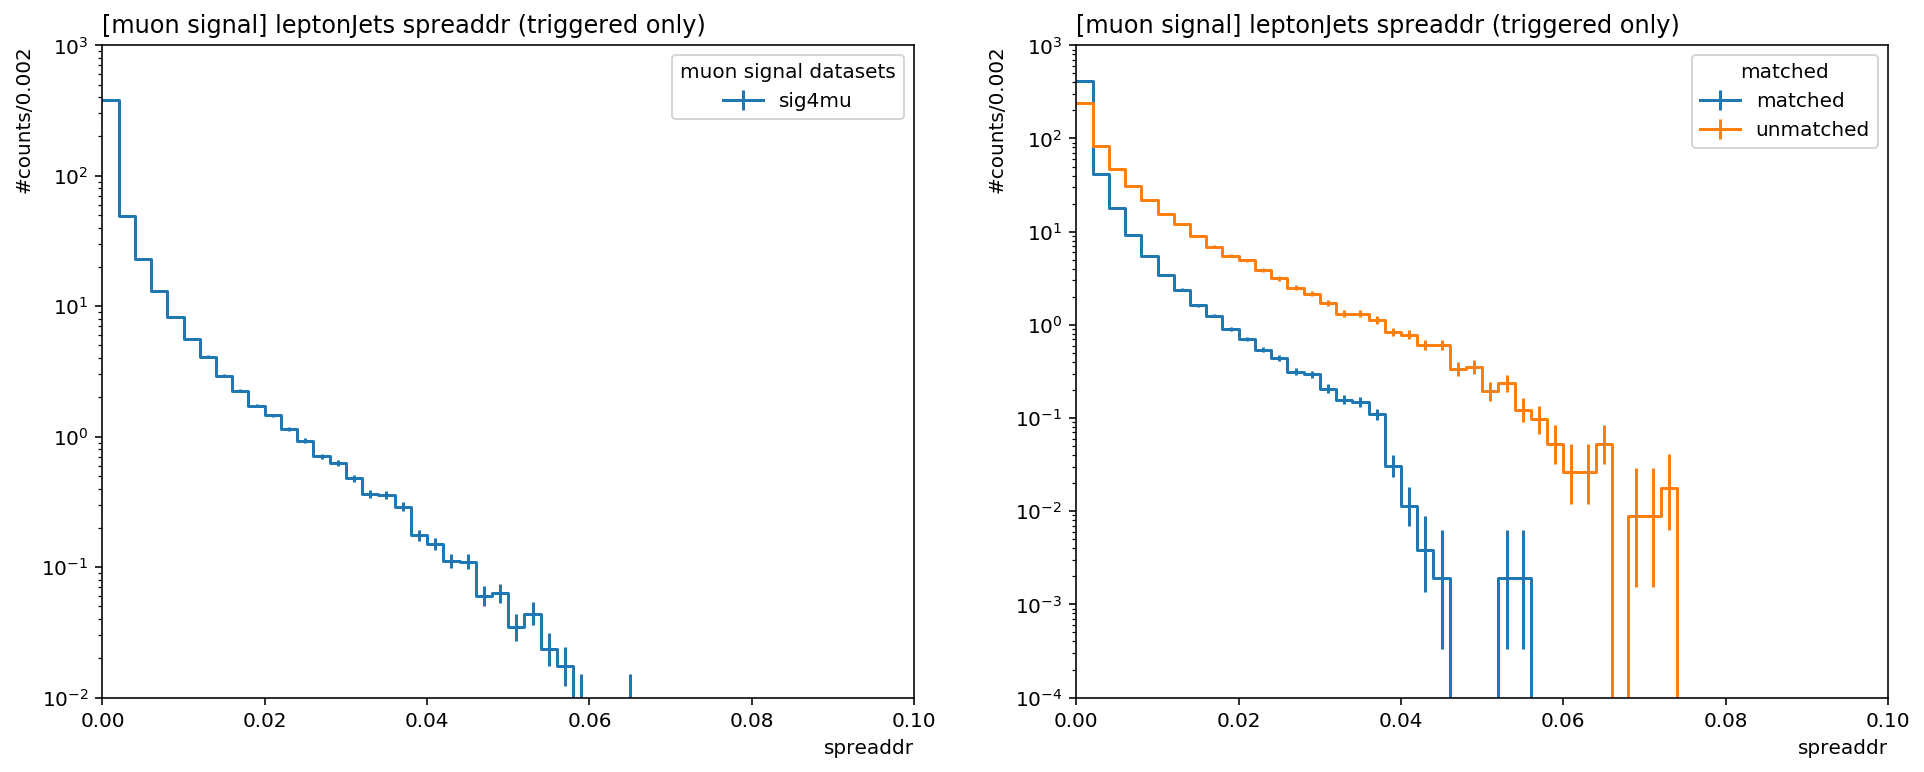

In [45]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['spreaddr'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['spreaddr'].project('dataset'), overlay='match', ax=axes[1], density=True)
axes[0].set_ylim([1e-2, 1e3])
axes[1].set_ylim([1e-4, 1e3])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[muon signal] leptonJets spreaddr (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

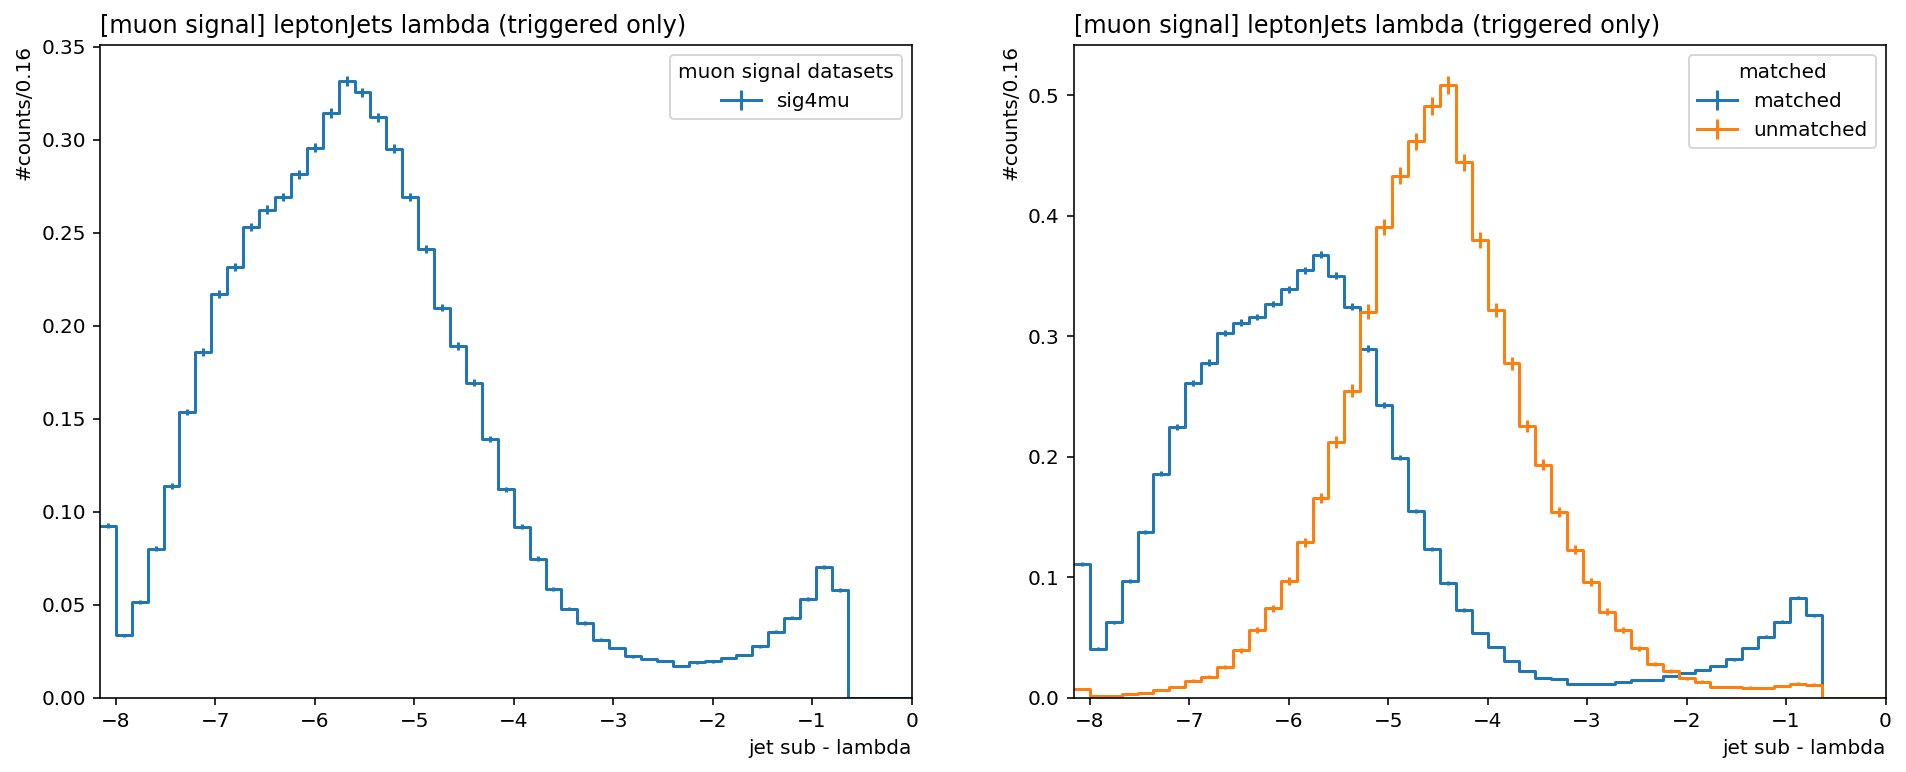

In [46]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['lamb'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='under')
fig, ax, _ = hist.plot1d(output['lamb'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='under')

for ax in axes:
    ax.set_title('[muon signal] leptonJets lambda (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

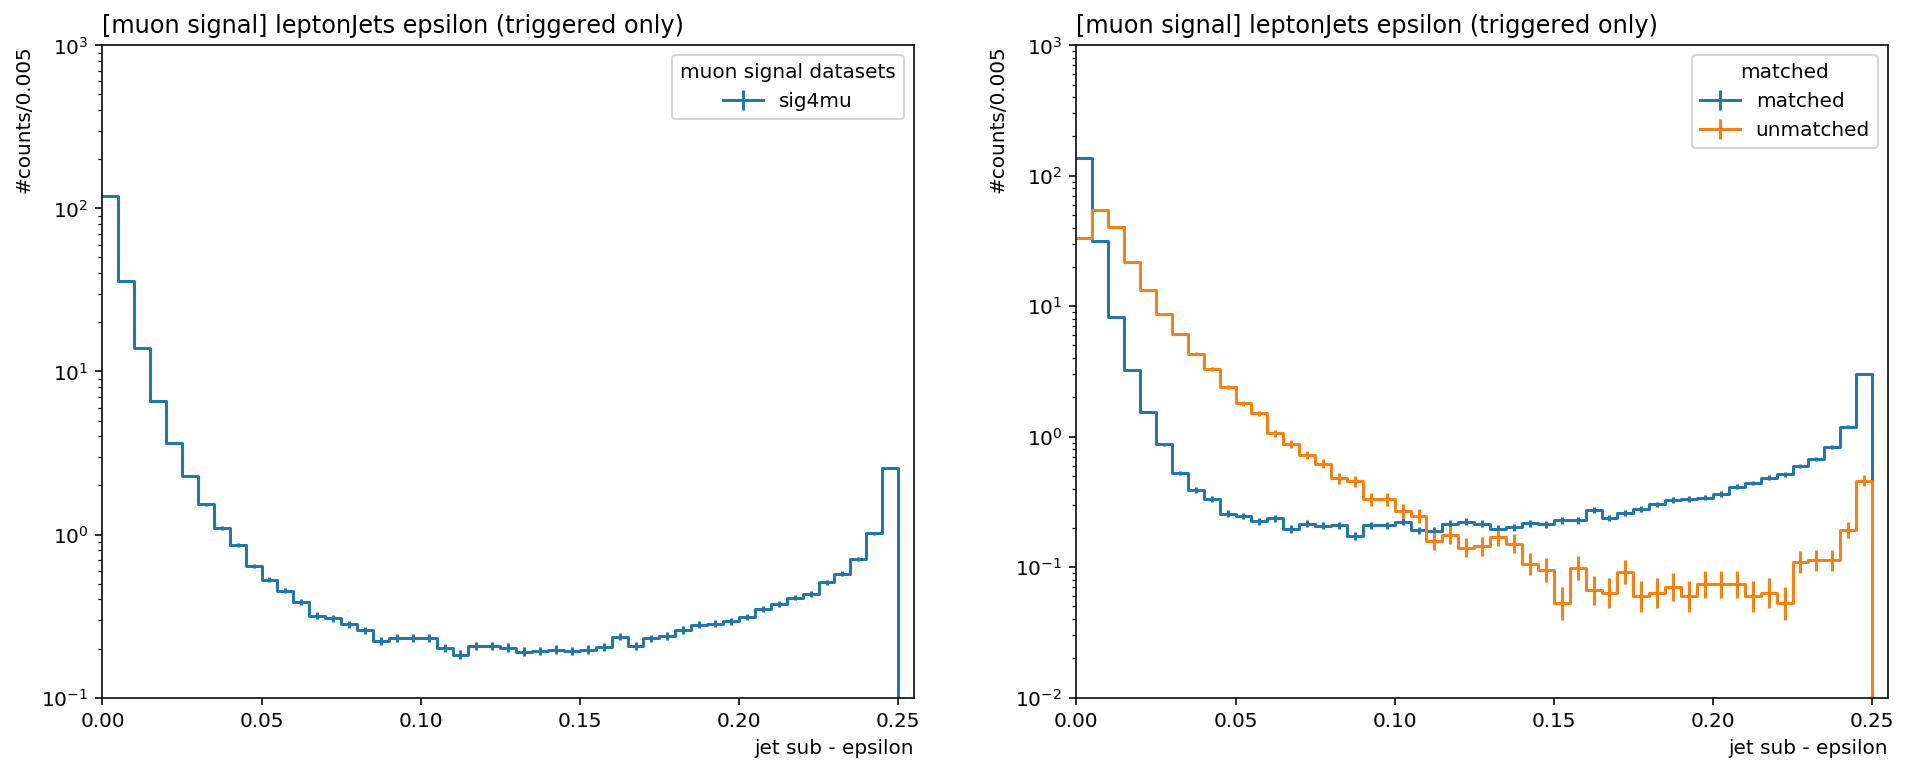

In [47]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['epsi'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='over')
fig, ax, _ = hist.plot1d(output['epsi'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='over')
axes[0].set_ylim([1e-1, 1e3])
axes[1].set_ylim([1e-2, 1e3])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[muon signal] leptonJets epsilon (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

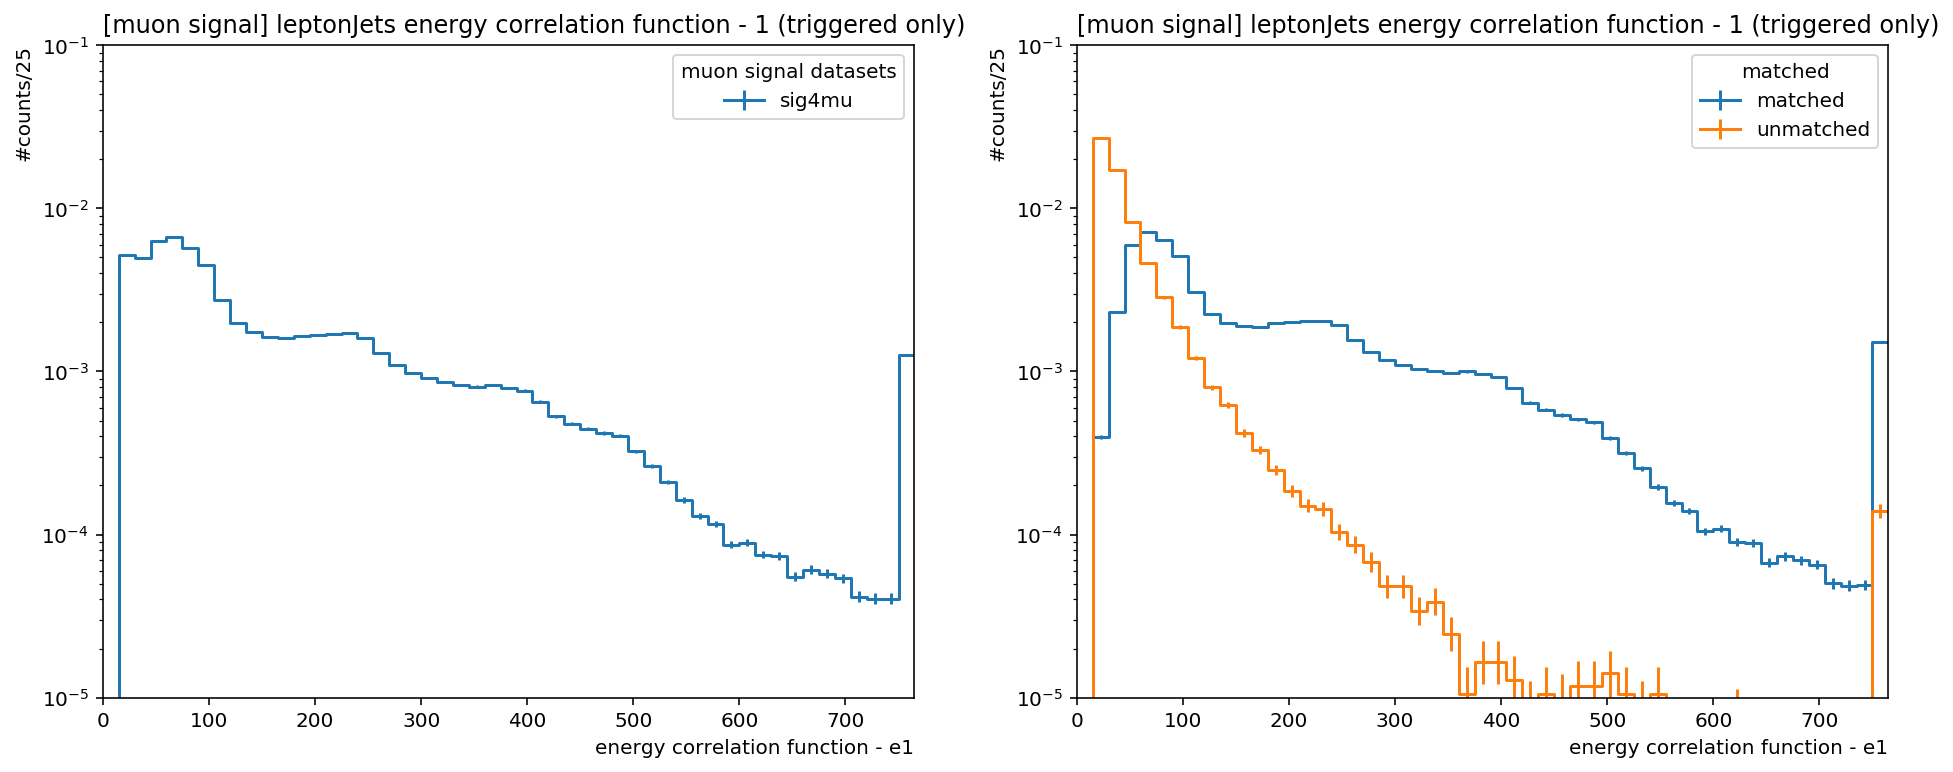

In [48]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['ecfe1'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='over')
fig, ax, _ = hist.plot1d(output['ecfe1'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='over')

for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim([1e-5, 1e-1])
    ax.set_title('[muon signal] leptonJets energy correlation function - 1 (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

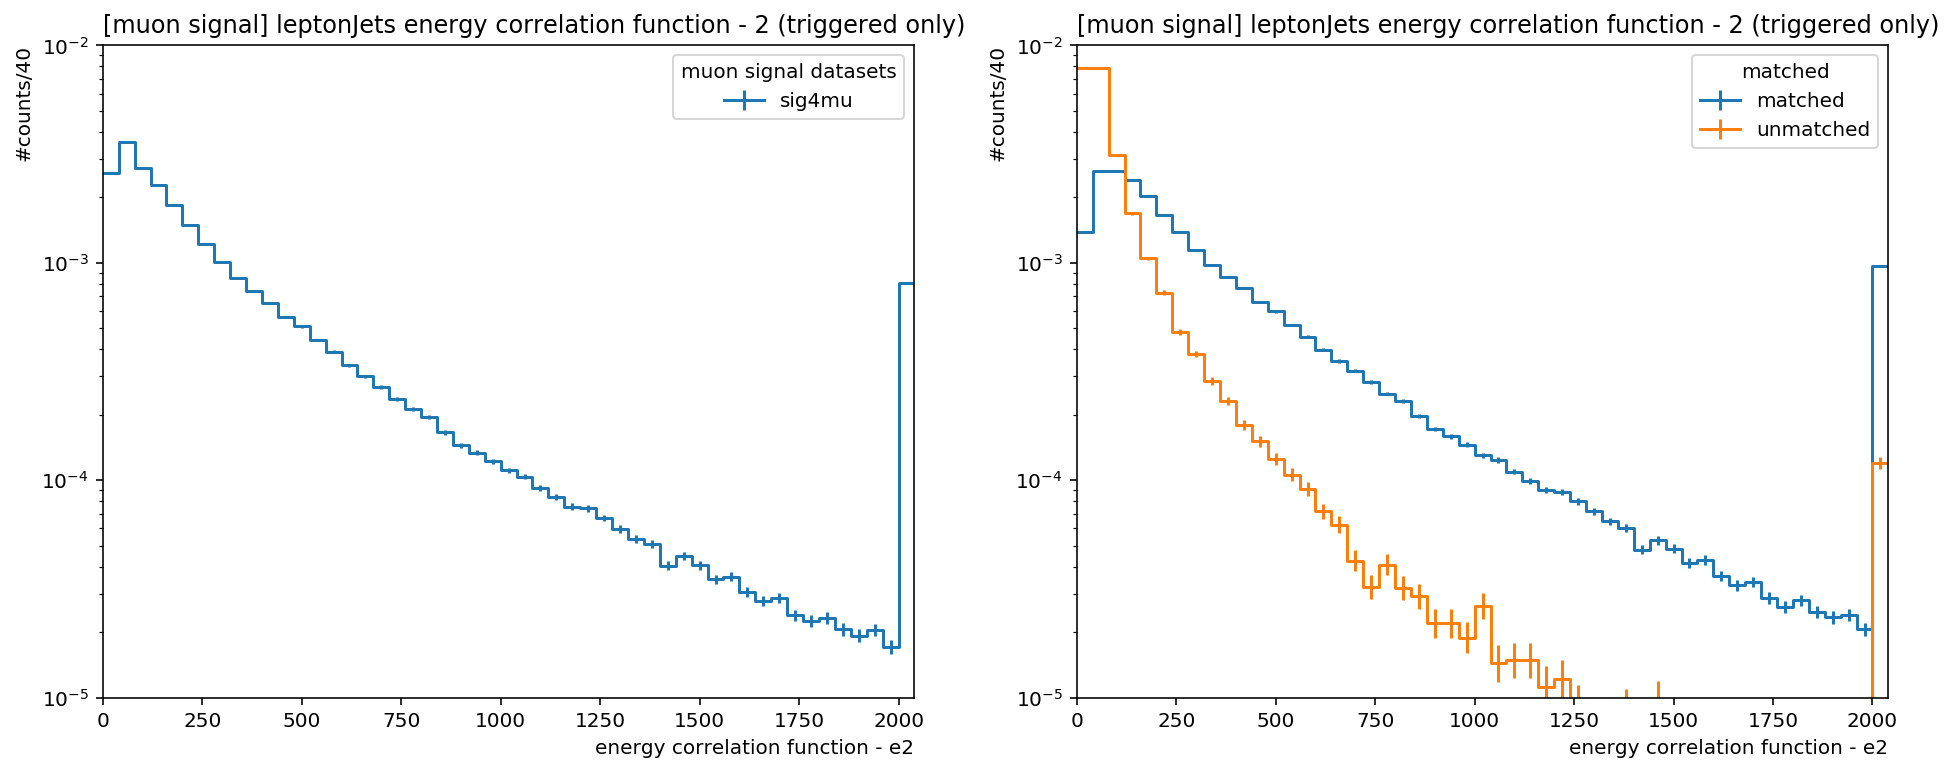

In [49]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['ecfe2'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='over')
fig, ax, _ = hist.plot1d(output['ecfe2'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='over')

for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim([1e-5, 1e-2])
    ax.set_title('[muon signal] leptonJets energy correlation function - 2 (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

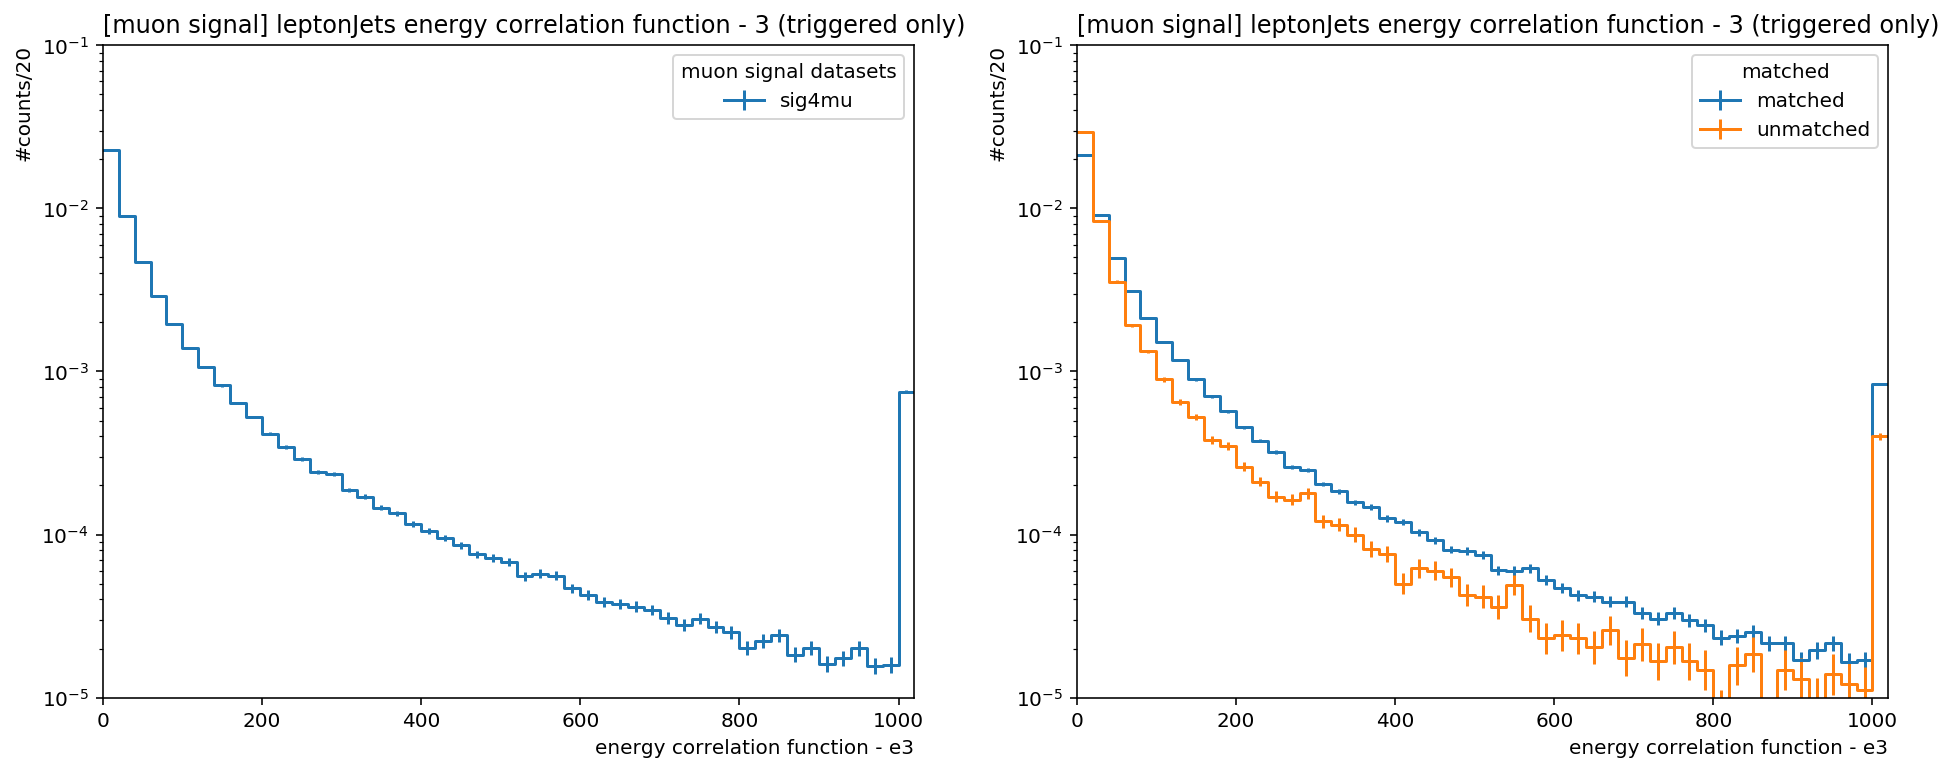

In [50]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['ecfe3'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='over')
fig, ax, _ = hist.plot1d(output['ecfe3'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='over')

for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim([1e-5, 1e-1])
    ax.set_title('[muon signal] leptonJets energy correlation function - 3 (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

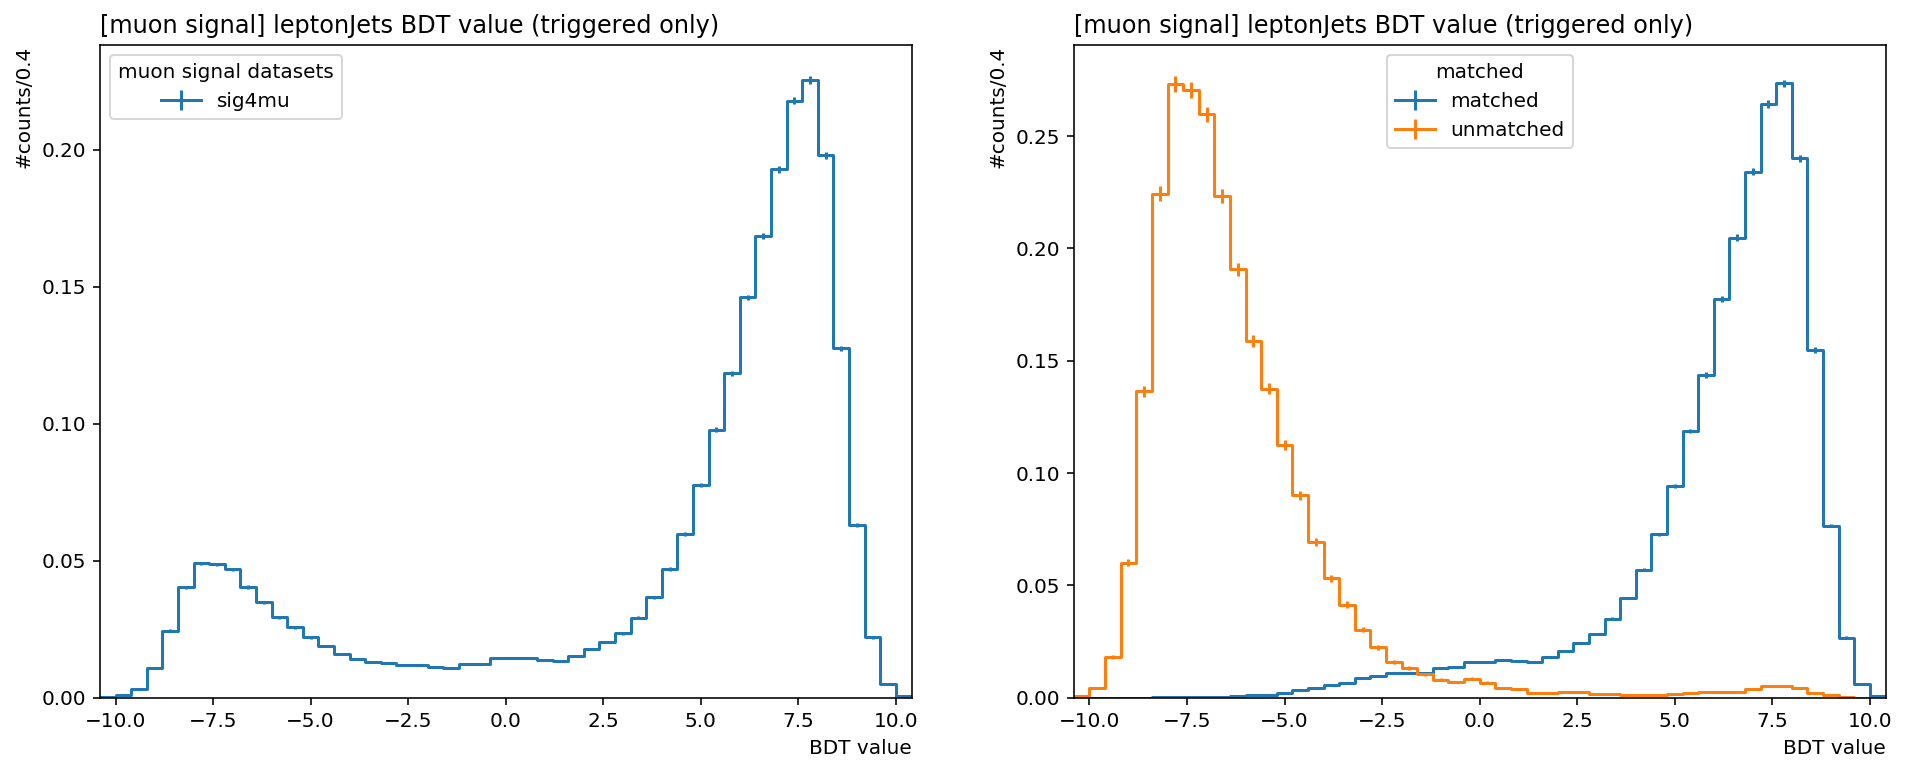

In [51]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['mva'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='all')
fig, ax, _ = hist.plot1d(output['mva'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='all')

for ax in axes:
    ax.set_title('[muon signal] leptonJets BDT value (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");